In [1]:
'''
File name: Project.ipynb
Date created: 01/11/2022
Date last modified: 20/12/2022
Python Version: 3.9.13
'''

'\nFile name: Project.ipynb\nDate created: 01/11/2022\nDate last modified: 20/12/2022\nPython Version: 3.9.13\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime #useful for date and time handling
import requests #used for getting data on the internet
from itertools import combinations  #used to create unique pairs from a list
import numpy as np
from scipy import stats #to compute p_values and assess significancy of our observations
import plotly.express as px  #for plots with integrated cursor for better visualization
#from pandas_profiling import ProfileReport

# Manage folder and saving results
import os

# Mainly used in language analysis
from bs4 import BeautifulSoup #used to parse the xml files 
from bs4 import SoupStrainer #used to get only the a subset of data in the xml file 
import gzip #used to unzip and open the xml files 
import re #used to remove all strange characters in string such as "?!" which impair comparinson between string and xml values
from wordcloud import WordCloud, STOPWORDS
from PIL import Image #used to open the mask for the wordclouds
import random
import spacy #used to apply the lemmatization
import en_core_web_sm #used to apply spacy on english sentences

# useful for good-looking and interactive plots
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

from scipy import stats

#Path to orignal datasets
DATA_FOLDER = 'MovieSummaries/'
#Path to NLP processed summaries
NLP_FOLDER = 'CoreNLP/corenlp_plot_summaries/'

#Path to save results to html and JPEG format
HTML_PATH = 'result/HTML/'
JPEG_PATH = 'result/JPEG/'
os.makedirs(HTML_PATH, exist_ok = True)
os.makedirs(JPEG_PATH, exist_ok = True)

### Lorading data

In [3]:
#Create dataframes from the orignal dataset 
moviedata = pd.read_csv(DATA_FOLDER + 'movie.metadata.tsv', sep = '\t', index_col='wiki_id' , header=None, names=('wiki_id','freebase_id','movie_name','release','revenue','runtime','languages','countries','genres'))
charadata = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', sep = '\t', header=None, names=('wiki_id','freebase_id','release','character_name','actor_dob','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','freebase_chara_map1','freebase_chara_map2','freebase_chara_map3'))
plots =  pd.read_csv(DATA_FOLDER + 'plot_summaries.txt', sep = '\t', header=None, names=('wiki_id','plot'))

In [4]:
display(moviedata.head(),charadata.head(),plots.head())

,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres
wiki_id,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


,wiki_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [5]:
#Set the commom index present in all datasets as wiki_id
charadata.set_index('wiki_id',inplace=True)
plots.set_index('wiki_id',inplace=True)

### Data Exploration

In [6]:
#Filter the three datasets to obtain only movies which have a list of characters and a plot summary
indexes = moviedata.index.intersection(charadata.index)
indexes = plots.index.intersection(indexes)

#Create new filtered dataset using indexes of movies common to the three datasets
moviedata_intersect = moviedata.loc[indexes]
charadata_intersect = charadata.loc[indexes]
plots_intersect = plots.loc[indexes]

In [7]:
print('We had originally the plot summaries of {} movies. After the intersect, we get a total of {} movies from which we have the characters and the plot summaries. Proportion filtered out: {:.2%}.\n'.format(len(plots),len(plots_intersect),1-(len(plots_intersect)/len(plots))))
print('The movie metadata contained originally {} movies. After filtering the dataset, we get {} movies. Proportion filtered out: {:.2%}.\n'.format(len(moviedata),len(moviedata_intersect),1-(len(moviedata_intersect)/len(moviedata))))
print('The character metadata contained originally {} characters. After filtering the dataset, we get {} characters. Proportion filtered out: {:.2%}.'.format(len(charadata),len(charadata_intersect),1-(len(charadata_intersect)/len(charadata))))
print('There are in average {:.2f} characters per movie.'.format(len(charadata_intersect)/len(moviedata_intersect)))

We had originally the plot summaries of 42303 movies. After the intersect, we get a total of 37779 movies from which we have the characters and the plot summaries. Proportion filtered out: 10.69%.

The movie metadata contained originally 81741 movies. After filtering the dataset, we get 37779 movies. Proportion filtered out: 53.78%.

The character metadata contained originally 450669 characters. After filtering the dataset, we get 308485 characters. Proportion filtered out: 31.55%.
There are in average 8.17 characters per movie.


### Profiling

The following cell gives us 3 files (available on github), containing a general overview of the datasets. From these reports, we found irregularities we tackled in the following cells.

In [8]:
#Creates the data profiling files, Can be run only once then commented

'''prof = ProfileReport(moviedata_intersect)
prof.to_file(output_file='moviedata_full.html')
prof = ProfileReport(charadata_intersect)
prof.to_file(output_file='charadata_full.html')
prof = ProfileReport(plots_intersect)
prof.to_file(output_file='plots_full.html')'''

"prof = ProfileReport(moviedata_intersect)\nprof.to_file(output_file='moviedata_full.html')\nprof = ProfileReport(charadata_intersect)\nprof.to_file(output_file='charadata_full.html')\nprof = ProfileReport(plots_intersect)\nprof.to_file(output_file='plots_full.html')"

#### Analysis resultig from profiling : 

Movies dataset :

- 80% of missing values in revenue : *We cannot use this feature*

- Outliers within runtime :  *We are not going to use this feature*

 Character dataset :  
 
- Unknown gender : *These actors play unnamed character in 80% of cases, we could avoid using them when running some analysis*

- Outlier in actor age : *225 values <0 probably due to mistakes, we take these values out to observe distribution*

- Ethnicity : *Hard to use, 75% of missing values*

- Height : *60% of missing values and outliers, anyway not relevant feature in our case*

Code to observe these statements : 

In [9]:
#Look at outliers in movies runtime
print("Number of movies with excessive (>400 min) runtime:", moviedata_intersect['runtime'][moviedata_intersect['runtime']>400].shape[0])
moviedata_intersect[moviedata_intersect['runtime']>400].head(5)


Number of movies with excessive (>400 min) runtime: 20


,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres
wiki_id,,,,,,,,
25930191,/m/0gxf936,Swallow the Sun,2009,NaN,1560.0,{},{},{}
147213,/m/012tj4,Shoah,1985,NaN,544.0,"{""/m/064_8sq"": ""French Language"", ""/m/03hkp"": ...","{""/m/0f8l9c"": ""France""}","{""/m/03g3w"": ""History"", ""/m/082gq"": ""War film""..."
2792417,/m/082yvg,War and Peace,1968-04-28,NaN,401.0,"{""/m/064_8sq"": ""French Language"", ""/m/06b_j"": ...","{""/m/05vz3zq"": ""Soviet Union"", ""/m/06bnz"": ""Ru...","{""/m/03g3w"": ""History"", ""/m/02l7c8"": ""Romance ..."
1060418,/m/042j6p,The 10th Kingdom,2000-02-27,NaN,417.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/015w9s..."
19653659,/m/04myhqx,TASS Is Authorized to Declare,1984,NaN,700.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/05vz3zq"": ""Soviet Union""}","{""/m/03k9fj"": ""Adventure""}"


As one can see, most of the other informations for runtime outliers (expect missing values that will be handled during data filtering) seem to be coherent. As the runtime is not considered for our analysis, we do not need to discard all movies associated to runtime outliers. 

In [10]:
#Look at missing values in actor_gender
print ("Proportion of character without name among actors whose gender is unknown : {0:.2%}".format(charadata_intersect['character_name'][charadata_intersect['actor_gender'].isna()].isna().sum()/len(charadata_intersect['character_name'][charadata_intersect['actor_gender'].isna()])))

Proportion of character without name among actors whose gender is unknown : 81.81%


As we can see, most of non specificied genders arise from unnamed characters, which probably means that these characters are negligable. Thus, we won't take these characters into acount when running analysis on genders.

In [11]:
#Look at outliers in actor age
print("Number of errors in actors age :",len(charadata_intersect[charadata_intersect['actor_age']<0]))
charadata_intersect[charadata_intersect['actor_age']<0].head()

Number of errors in actors age : 225


,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3
wiki_id,,,,,,,,,,,,
22829,/m/05q8n,1965-06-01,The Black Ghoul,1978-07-18,F,NaN,/m/03ts0c,Cheyenne Silver,-13.0,/m/0cbwtz8,/m/0cbwtzc,/m/06616j
4210812,/m/0bq4vz,1910-03-24,Glinda,1992-02-17,M,NaN,NaN,Olive Cox,-81.0,/m/09z696c,/m/022qn6,/m/09z696h
5626726,/m/0dx12p,1936-02-14,NaN,1944-12-09,M,NaN,NaN,Bob O'Connor,-8.0,/m/0k4k1m,NaN,/m/064_gh
7735007,/m/0kvg60,1966,NaN,1996-08-14,M,NaN,NaN,Jack Fletcher,-30.0,/m/0gcmsrc,NaN,/m/07p1ck
6667989,/m/0ggp41,1960-09-22,Khalillah,1989-05-05,F,1.6,NaN,Larissa Wilson,-28.0,/m/063lmhz,/m/063lmj0,/m/02pv8ss


There are 225 outliers with incoherent values for the age, most likely due to errors.

#### Get some of the missing information back

We can see that quite a lot of character's data is missing. We can try to retrieve some of it thanks to the film's, the character's and the actor/actress's freebase ids, respectively the last three columns of the dataframe. We can use the [freebase API](https://developers.google.com/freebase#freebase-wikidata-mappings) which dates back to 2013 and has a mapping between freebase ids and Wikidata using N-Triples RDF. This will allows us to potentially get data back from the corresponding Wikipedia page.

In [12]:
path =  "data_freebase_wiki/fb2w.nt.gz"
f_w_mapping = pd.read_csv(path, sep='\t', header=None, skiprows=4, names=["Freebase", "W3Consortium", "Wikidata"])
f_w_mapping.head()

,Freebase,W3Consortium,Wikidata
0,<http://rdf.freebase.com/ns/m.0695j>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q6718> .
1,<http://rdf.freebase.com/ns/m.05nrg>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q538> .
2,<http://rdf.freebase.com/ns/m.0jgd>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q414> .
3,<http://rdf.freebase.com/ns/m.0d_23>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q2537> .
4,<http://rdf.freebase.com/ns/m.04g7d>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q315> .


In [13]:
# Extracts the freebase id from the url
# Input : url
def extract_freebase_id(url):
    return "/m/" + url[30:-1] #get info between the m. and > symbols in the url

# Extracts the Wikidata id from the url
# Input : url
def extract_wiki_id(url):
    return url[32:-3] #get info between the "entity/" and "> ." symbols in the url

In [14]:
# collect all IDs in a dataframe to create the pairs between the freebase and the wiki
f_w_id = pd.DataFrame(columns = ["FreeId","WikiQID"])
f_w_id["FreeId"] = f_w_mapping.Freebase.apply(extract_freebase_id)
f_w_id["WikiQID"] = f_w_mapping.Wikidata.apply(extract_wiki_id)

f_w_id.head()

,FreeId,WikiQID
0,/m/0695j,Q6718
1,/m/05nrg,Q538
2,/m/0jgd,Q414
3,/m/0d_23,Q2537
4,/m/04g7d,Q315


In [15]:
print("There are {} actor/actress' Freebase Ids in the mapping which are also present in the character dataset.".format(charadata_intersect.freebase_chara_map3.isin(f_w_id["FreeId"]).sum()))

There are 202520 actor/actress' Freebase Ids in the mapping which are also present in the character dataset.


In [16]:
# We link the pairs above to original dataset thanks to the freebase IDs (column: "freebase_chara_map3") 
charadata_intersect = charadata_intersect.reset_index()
charadata_intersect = charadata_intersect.merge(f_w_id, how="left", left_on="freebase_chara_map3", right_on="FreeId")
charadata_intersect.head()

,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3,FreeId,WikiQID
0,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj,NaN,NaN
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc,/m/06trhc,Q2369235
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6,/m/01n4sp6,Q362776
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,NaN,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv,/m/08087zv,Q4218267
4,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg,NaN,NaN


##### Get some of the gender information back

As we base our analysis on the gender we need to try to get back some missing gender information.

In [17]:
former_na_nb = charadata_intersect['actor_gender'].isna().sum()
print("We have {} missing gender.".format(former_na_nb))

We have 30066 missing gender.


In [18]:
charadata_intersect.drop(columns=["FreeId"], inplace=True) #no neeed for this redundant column

# get temporary dataframe for data with missing gender and for which we have a Wiki Id
missing_gender = charadata_intersect[(charadata_intersect['actor_gender'].isna() & ~charadata_intersect['WikiQID'].isna())]
map_actor_gender = pd.DataFrame(missing_gender.WikiQID.unique(), columns=["WikiQID"]).dropna()
map_actor_gender["actor_gender"] = None
map_actor_gender.head()

,WikiQID,actor_gender
0,Q4218267,None
1,Q589836,None
2,Q1134162,None
3,Q4275805,None
4,Q2311526,None


In [19]:
# Get json file from Wikidata using the QID and extract the gender or sex property (noted P21 in Wikidata)
def get_gender_from_json(actor_WikiQID):

    url = "https://www.wikidata.org/wiki/Special:EntityData/" + actor_WikiQID + ".json"
    value = None

    try:
        r = requests.get(url)
        file = r.json()
        value = file['entities'][actor_WikiQID]['claims']['P21'][0]['mainsnak']['datavalue']['value']['id']
    except: 
        pass

    return value

In [20]:
map_actor_gender.actor_gender = map_actor_gender.WikiQID.apply(get_gender_from_json)

display(map_actor_gender.head(),"The QIDs of the newly found genders are:",  list(map_actor_gender['actor_gender'].unique()))

,WikiQID,actor_gender
0,Q4218267,Q6581097
1,Q589836,Q6581097
2,Q1134162,Q6581072
3,Q4275805,Q6581097
4,Q2311526,Q6581072


'The QIDs of the newly found genders are:'

['Q6581097', 'Q6581072', None, 'Q44148', 'Q1052281', 'Q43445']

In [21]:
# Convert the Wikidata QID to actual gender either 'M' for male and 'F' for female and transgender female.
# The meaning of the QID is taken from the Wikidata webpage of the sex or gender property of Wikipedia entities (https://www.wikidata.org/wiki/Property:P21)
def convert_QID(QID):
    if (QID == 'Q6581097') or (QID == 'Q44148'):
        return 'M'
    elif (QID == 'Q6581072') or (QID == 'Q43445') or (QID == 'Q1052281'):
        return 'F'

    return None

In [22]:
#convert genders QIDs to actual gender letter (M or F)
map_actor_gender.actor_gender = map_actor_gender.actor_gender.apply(convert_QID)
map_actor_gender.head()

,WikiQID,actor_gender
0,Q4218267,M
1,Q589836,M
2,Q1134162,F
3,Q4275805,M
4,Q2311526,F


In [23]:
# merge collected data to the original dataset
charadata_intersect = charadata_intersect.merge(map_actor_gender, suffixes=('', '_2'), how="left", left_on="WikiQID", right_on="WikiQID")#.drop(columns= ["WikiQID"])
charadata_intersect.head()

,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3,WikiQID,actor_gender_2
0,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj,NaN,NaN
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc,Q2369235,NaN
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6,Q362776,NaN
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,NaN,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv,Q4218267,M
4,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg,NaN,NaN


In [24]:
# Replace missing value with acutal gender if found
charadata_intersect["actor_gender"] = charadata_intersect["actor_gender"].fillna(charadata_intersect["actor_gender_2"])
charadata_intersect.drop(columns=["actor_gender_2"], inplace=True)
print("We have gained {} gender identifications.".format(former_na_nb - charadata_intersect['actor_gender'].isna().sum()))
display("here we can see that the 4th character has recovered its missing gender.", charadata_intersect.head())

We have gained 875 gender identifications.


'here we can see that the 4th character has recovered its missing gender.'

,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3,WikiQID
0,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj,NaN
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc,Q2369235
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6,Q362776
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,M,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv,Q4218267
4,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg,NaN


##### Get some of the dates of birth information back

In [25]:
# We consider that a negative age and an age superior to 120 years-old are not normal so we will recollect the dob to recompute it
charadata_intersect.loc[charadata_intersect['actor_age'] < 0, 'actor_dob'] = None
charadata_intersect.loc[charadata_intersect['actor_age'] > 120, 'actor_dob'] = None
charadata_intersect.loc[charadata_intersect['actor_age'] < 0, 'actor_age'] = None
charadata_intersect.loc[charadata_intersect['actor_age'] > 120, 'actor_age'] = None

# We consider that the release date is more reliable than the dob so any actor/actress said to be born after the release has his/her dob set to None
charadata_intersect.loc[charadata_intersect['actor_dob'] > charadata_intersect['release'], 'actor_dob'] = None

missing_dob = charadata_intersect[(charadata_intersect['actor_dob'].isna() & ~charadata_intersect['WikiQID'].isna())]
map_actor_dob = pd.DataFrame(missing_dob.WikiQID.unique(), columns=["WikiQID"]).dropna()
map_actor_dob["actor_dob"] = None
map_actor_dob.head()

,WikiQID,actor_dob
0,Q589836,None
1,Q1134162,None
2,Q7030156,None
3,Q3998297,None
4,Q7283589,None


In [26]:
# Get json file from Wikidata using the QID and extract the date of birth property (noted P569 in Wikidata)
def get_dob_from_json(actor_WikiQID):

    url = "https://www.wikidata.org/wiki/Special:EntityData/" + actor_WikiQID + ".json"
    dob = None

    try:
        r = requests.get(url)
        file = r.json()
        dob = file['entities'][actor_WikiQID]['claims']['P569'][0]['mainsnak']['datavalue']['value']['time']
        format_data = "+%Y-%m-%dT%H:%M:%SZ"
        dob = datetime.strptime(dob, format_data).date()
    except: 
        pass

    return dob

In [27]:
# get actor dob with Wikidata QID
map_actor_dob.actor_dob = map_actor_dob.WikiQID.apply(get_dob_from_json)

charadata_intersect = charadata_intersect.merge(map_actor_dob, suffixes=('', '_2'), how="left", left_on="WikiQID", right_on="WikiQID").drop(columns= ["WikiQID"])
charadata_intersect.head()

former_na_dob = charadata_intersect['actor_dob'].isna().sum()
charadata_intersect["actor_dob"] = charadata_intersect["actor_dob"].fillna(charadata_intersect["actor_dob_2"])
charadata_intersect.drop(columns=["actor_dob_2"], inplace=True)
print("We have gained {} dates of birth identifications.".format(former_na_dob - charadata_intersect['actor_dob'].isna().sum()))
charadata_intersect.head()

We have gained 4309 dates of birth identifications.


,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3
0,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,M,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv
4,23890098,/m/076w2lb,1990-09-07,NaN,NaN,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg


In [28]:
# recompute actor age at the time of the movie release
charadata_intersect['release'] = pd.to_datetime(charadata_intersect['release'].astype(str), errors = 'coerce')
charadata_intersect['actor_dob'] = pd.to_datetime(charadata_intersect['actor_dob'].astype(str), errors = 'coerce')
charadata_intersect['actor_dob'] = charadata_intersect.actor_dob.apply(lambda x : pd.to_datetime(x).date())
charadata_intersect['actor_age'] = ((pd.to_datetime(charadata_intersect['release']) - pd.to_datetime(charadata_intersect['actor_dob'])).dt.days)//365.25

charadata_intersect.head()

,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3
0,23890098,/m/076w2lb,1990-09-07,NaN,NaT,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,M,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv
4,23890098,/m/076w2lb,1990-09-07,NaN,NaT,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg


##### Get some of the characters' name information back

In [29]:
print("There are {} character Freebase Ids in the mapping which are also present in the character dataset.".format(charadata_intersect.freebase_chara_map2.isin(f_w_id["FreeId"]).sum()))

There are 3884 character Freebase Ids in the mapping which are also present in the character dataset.


In [30]:
charadata_intersect = charadata_intersect.merge(f_w_id, how="left", left_on="freebase_chara_map2", right_on="FreeId")
charadata_intersect.drop(columns=["FreeId"], inplace=True) #no neeed for this redundant column
charadata_intersect.head()

,wiki_id,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3,WikiQID
0,23890098,/m/076w2lb,1990-09-07,NaN,NaT,NaN,NaN,NaN,Natalia Koliakanova,NaN,/m/0gby7pd,NaN,/m/0gby7pj,NaN
1,23890098,/m/076w2lb,1990-09-07,NaN,1951-04-14,M,NaN,NaN,Pyotr Mamonov,39.0,/m/07lld1w,NaN,/m/06trhc,NaN
2,23890098,/m/076w2lb,1990-09-07,NaN,1919-10-08,M,NaN,/m/0x67,Hal Singer,70.0,/m/0gc0hbm,NaN,/m/01n4sp6,NaN
3,23890098,/m/076w2lb,1990-09-07,NaN,1926-10-26,M,NaN,NaN,Vladimir Kashpur,63.0,/m/0gc3tz0,NaN,/m/08087zv,NaN
4,23890098,/m/076w2lb,1990-09-07,NaN,NaT,NaN,NaN,NaN,Pyotr Zaychenko,NaN,/m/0gcjqgq,NaN,/m/0clzzrg,NaN


In [31]:
intersection = charadata_intersect['character_name'][(charadata_intersect['character_name'].isna() & ~charadata_intersect['WikiQID'].isna())].sum()
print("There are {} Wikidata QID corresponding to missing character name.".format(intersection))

There are 0 Wikidata QID corresponding to missing character name.


In [32]:
charadata_intersect.set_index('wiki_id', inplace=True)
charadata_intersect.drop(columns= ["WikiQID"], inplace=True)

All the Freebase Ids present in the Freebase ID - Wikidata mapping dataset are for characters which already have a name. We thus cannot ge back missing character names with the Freebase ID - Wikidata mapping.

#### Filtering data

Here we remove all columns that will not be useful for the further analysis. In addition, we remove all characters with missing values in release date and/or gender as we want to study women's representation over time. We can see that the format of the release date is not constant and thus we need to homogenize it into only the year of the release.

In [33]:
#For each character, drop columns which have no use for our analysis and homogenize the release date 
charadata_filtered = charadata_intersect.drop(['freebase_id','actor_dob', 'actor_height', 'actor_ethnicity', 'freebase_chara_map1','freebase_chara_map2','freebase_chara_map3'], axis = 1)
charadata_filtered['release'] = pd.to_datetime(charadata_filtered['release'], errors = 'coerce')
charadata_filtered['release'] = pd.DatetimeIndex(charadata_filtered['release']).year
charadata_filtered = charadata_filtered[charadata_filtered['release'].notna()]
charadata_filtered['release'] = charadata_filtered['release'].astype(int)

#drop characters who do not have a gender
charadata_filtered = charadata_filtered[charadata_filtered['actor_gender'].notna()] 
#remove characters with negative ages values and highly anormal values (>120)
charadata_filtered = charadata_filtered[(charadata_filtered['actor_age']>=0) & (charadata_filtered['actor_age']<120)]

#For each movie, drop columns which have no use for our analysis and homogenize the release date
moviedata_filtered = moviedata_intersect.drop(['freebase_id','revenue','runtime','languages'], axis = 1)
moviedata_filtered['release'] = pd.to_datetime(moviedata_filtered['release'], errors = 'coerce')
moviedata_filtered['release'] = pd.DatetimeIndex(moviedata_filtered['release']).year
moviedata_filtered = moviedata_filtered[moviedata_filtered['release'].notna()]
moviedata_filtered['release'] = moviedata_filtered['release'].astype(int)

#Remove the genre ID (e.g. /m/07s9rl0)to get only the string of the genres to allow analysis
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda x : x.replace(':', ','))
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(eval)
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda x: list(x))
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda y: list(filter(lambda x: not x.startswith('/m'), y)))
#do the same for the countries names
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda x : x.replace(':', ','))
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(eval)
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda x: list(x))
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda y: list(filter(lambda x: not x.startswith('/m'), y)))

#Keep only the overlap of the three datasets to obtain only movies which have a list of characters and a plot summary after the filter
indexes_filtered = moviedata_filtered.index.intersection(charadata_filtered.index)
indexes_filtered = plots.index.intersection(indexes_filtered)

moviedata_filtered = moviedata_filtered.loc[indexes_filtered]
charadata_filtered = charadata_filtered.loc[indexes_filtered]
plots_filtered = plots_intersect.loc[indexes_filtered]

moviedata_filtered.head()

,movie_name,release,countries,genres
wiki_id,,,,
23890098,Taxi Blues,1990,"[France, Russia, Soviet Union]","[World cinema, Drama]"
31186339,The Hunger Games,2012,[United States of America],"[Drama, Action/Adventure, Action, Science Fict..."
20663735,Narasimham,2000,[India],"[Drama, Bollywood, Action, Musical]"
2231378,The Lemon Drop Kid,1951,[United States of America],"[Comedy, Screwball comedy]"
595909,A Cry in the Dark,1988,"[United States of America, Australia, New Zeal...","[Courtroom Drama, Docudrama, Drama, World cine..."


In [34]:
#We look at the missing information for the remainings movies in the movie metadata
moviedata_filtered.isna().sum()

movie_name    0
release       0
countries     0
genres        0
dtype: int64

In [35]:
#We look at the missing information for the remainings movies in the movie metadata
charadata_filtered.isna().sum()

release                0
character_name    122830
actor_gender           0
actor_name            48
actor_age              0
dtype: int64

The most relevant columns for our anlysis are clear from missing data.

#### Visualization

First, we want to study the proportions of male and female characters across all movies from the dataset, to gain insight on the relative gender proportions in the whole dataset.
For our whole analysis we have assumed for simplicity that actore/actress play only characters of the same gender, thus the actor/actress' gender and the character's gender are identical. 

In [36]:
# Save good looking pie chart of female and male proportions
# Input: Male proportion (between 0 and 1), female proportion (between 0 and 1) and figure name to save it to JPEG format
def piechart(M_proportion, F_proportion, FIG_NAME):
    fig = px.pie(values=[M_proportion, F_proportion], names=["Male", "Female"], 
                height=330, width=660, 
                hole=0.7, 
                color_discrete_sequence=['#4c78a8', 'red'])
    fig.update_traces(hovertemplate=None, textposition='outside',
                    textinfo='percent+label', rotation=50)
    fig.update_layout(margin=dict(t=50, b=30, l=0, r=0), showlegend=False,
                            plot_bgcolor='white', paper_bgcolor='white',
                            font=dict(size=17, color='#8a8d93'),
                            hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
    fig.add_annotation(dict(x=0.5, y=0.4,  align='center',
                            xref = "paper", yref = "paper",
                            showarrow = False, font_size=22,
                            text="<span style='font-size: 15px; color=#555'>Gender repartition</span>"))
    fig.add_layout_image(
        dict(
            source=Image.open("Images/Female.jpg"),
            xref="paper", yref="paper",
            x=0.50, y=0.48,
            sizex=0.2, sizey=0.2,
            xanchor="right", yanchor="bottom", sizing= "contain",
        )
    )
    fig.add_layout_image(
        dict(
            source=Image.open("Images/Male.jpg"),
            xref="paper", yref="paper",
            x=0.6, y=0.48,
            sizex=0.2, sizey=0.2,
            xanchor="right", yanchor="bottom", sizing= "contain",
        )
    )
    pio.write_image(fig, file = JPEG_PATH + FIG_NAME, format = 'svg')

First we wish to have a look at the numbers and proportions of male and female characters across all movies :
There are 158769 male characters, corresponding to 67.09% of all characters
There are 77886 female characters, corresponding to 32.91% of all characters


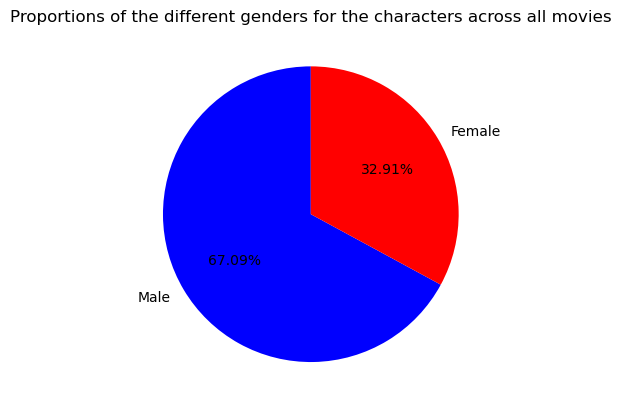

In [37]:
#Assess women's presence accross all charaters from every movies
M_count = charadata_filtered[charadata_filtered.actor_gender == 'M'].shape[0]
F_count = charadata_filtered[charadata_filtered.actor_gender == 'F'].shape[0]

M_proportion = M_count / (M_count + F_count)
F_proportion = F_count / (M_count + F_count)

print("First we wish to have a look at the numbers and proportions of male and female characters across all movies :")
print("There are {} male characters, corresponding to {:.2f}% of all characters".format(M_count, M_proportion*100))
print("There are {} female characters, corresponding to {:.2f}% of all characters".format(F_count, F_proportion*100))

plt.pie([M_proportion, F_proportion], labels = ["Male", "Female"], startangle = 90, autopct = "%0.2f%%",colors=['blue','red'])
plt.title("Proportions of the different genders for the characters across all movies")
plt.show()

piechart(M_proportion, F_proportion,'general_pie.svg') # save plot

This result shows us that men seem to be heavily more represented, we will thus decompose these values in order to observe what underlies this trend. In consequence, we want to further assess the relative gender representation by looking at the relative proportions of male and female characters in each movie.

In [38]:
#Assess average gender presence per movie 
gender_count_permovie = charadata_filtered.groupby('wiki_id').apply(lambda x : pd.Series({'nb_male' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'nb_female' : x[x.actor_gender == 'F'].shape[0]}))
                                                                                       
#Compute proportions of each gender per movie
gender_count_permovie['M_proportion'] = gender_count_permovie.nb_male / (gender_count_permovie.nb_male + gender_count_permovie.nb_female)
gender_count_permovie['F_proportion'] = gender_count_permovie.nb_female / (gender_count_permovie.nb_male + gender_count_permovie.nb_female)

gender_count_permovie.head()

,nb_male,nb_female,M_proportion,F_proportion
wiki_id,,,,
330,0,4,0.000000,1.000000
3217,9,3,0.750000,0.250000
3333,8,6,0.571429,0.428571
3746,10,3,0.769231,0.230769
3837,18,2,0.900000,0.100000


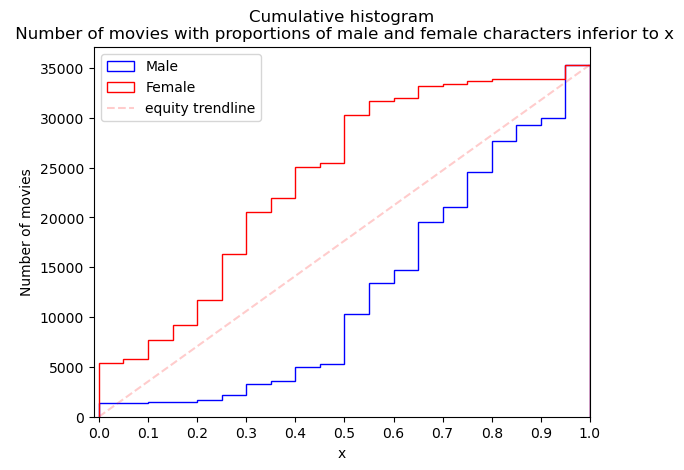

In [39]:
plt.hist(gender_count_permovie.M_proportion, bins = 20, cumulative = True, histtype = 'step',label='Male',color='blue')
plt.hist(gender_count_permovie.F_proportion, bins = 20, cumulative = True, histtype = 'step',label='Female',color='red')
plt.plot([0,1], [0, gender_count_permovie.shape[0]], color = 'red', ls = '--', alpha = 0.2, label = 'equity trendline')
plt.xlim(-0.01,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.title("Cumulative histogram\n Number of movies with proportions of male and female characters inferior to x")
plt.xlabel('x')
plt.ylabel('Number of movies')
plt.legend(loc='upper left')
plt.show()

The graph above presents two cumulative histograms representing the number of movies in which the proportion of male or female characters is inferior to the corresponding proportion on the x-axis.

The dotted "equity trendline" represents the expected form of the cumulative histograms if the representations of each gender were equal, in the sens that the proportions of movies in which there is less than a certain proportion x of female (or male characters) should be equal to a proportion x of all movies. 

Therefore, any cumulative histogram under this trendline is biased towards the gender that it represents (i.e., this gender would be over-represented) and any cumulative histogram over the trendline represent a gender that would be under-represented. 

As one can see, male characters are significantly more represented than female characters as the numbers of movies in which they are show a certain proportion **x** of male characters which is always higher than this proportion **x** of the total numbers of movies. In the same way, female characters are significantly under-represented.

Below, we look at the proportion of movies starring different number of male and female actors. 

In [40]:
max_M = 0
max_F = 0
equal_MF = 0
for i in range(gender_count_permovie.shape[0]) :
    if (gender_count_permovie.iloc[i]['nb_male'] > gender_count_permovie.iloc[i]['nb_female']) :
        max_M += 1
    elif (gender_count_permovie.iloc[i]['nb_male'] < gender_count_permovie.iloc[i]['nb_female']) : 
        max_F += 1
    elif (gender_count_permovie.iloc[i]['nb_male'] == gender_count_permovie.iloc[i]['nb_female']) :
        equal_MF += 1

print(f'The number of movies with more male actors than female actors is : {max_M}.')
print(f'The number of movies with more female actors than male actors is : {max_F}.')
print(f'The number of movies with equal number of male and female actors is : {equal_MF}.')

The number of movies with more male actors than female actors is : 25479.
The number of movies with more female actors than male actors is : 5248.
The number of movies with equal number of male and female actors is : 4598.


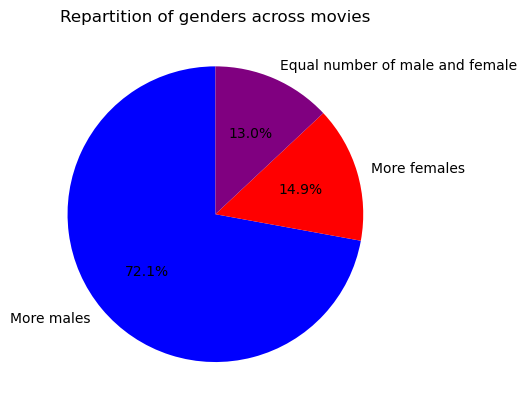

In [41]:
plt.pie([max_M,max_F,equal_MF], labels = ["More males", "More females", "Equal number of male and female"], startangle = 90, autopct = "%0.1f%%",colors=['blue','red','purple'])
plt.title("Repartition of genders across movies")
plt.show()

To further analyze men and women representation in movies, we computed the mean, median and std of the number of movies each gender stars in. This helps to show further differences, as men tend to play in more movies than women.

In [42]:
movies_count_peractor = charadata_filtered.groupby('actor_name').apply(lambda x : pd.Series({'actor_gender' : x['actor_gender'].unique()[0], 
                                                                                       'num_movies' : x.index.nunique()}))
movies_count_peractor.head()

,actor_gender,num_movies
actor_name,,
'King Kong' Kashey,M,1
2 Tuff Tony,M,1
40 Glocc,M,1
50 Cent,M,15
A Martinez,M,9


In [43]:
mean_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).mean()
mean_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).mean()
median_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).median()
median_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).median()
std_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).std()
std_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).std()
print('Median number of movies per male actor =',median_M,'mean number of movies per male actor =',mean_M, 'std =',std_M)
print('Median number of movies per female actor =',median_F,'mean number of movies per female actor =',mean_F, 'std =',std_F)

Median number of movies per male actor = 2.0 mean number of movies per male actor = 5.39216426879099 std = 9.63843306422011
Median number of movies per female actor = 2.0 mean number of movies per female actor = 4.425853770341508 std = 6.494594953589492


Finally, another crucial aspect looking at women representation is the difference in age between men and women in movies. Indeed, women tend to be represented younger than men, and we wanted to assess this statement by looking at the distribution of ages of actors between genders.

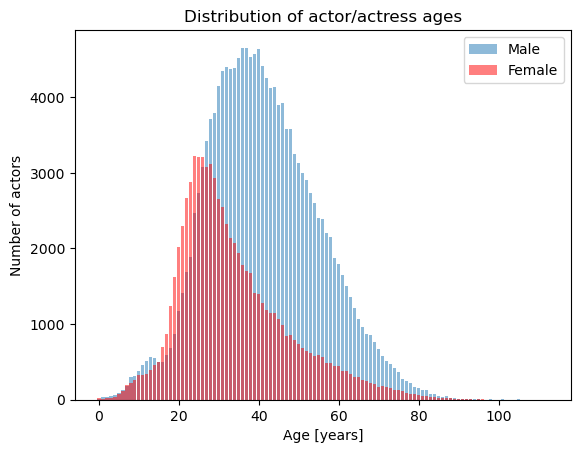

In [44]:
#Plot age distribution across gender
M = charadata_filtered[charadata_filtered['actor_gender']=='M']
F = charadata_filtered[charadata_filtered['actor_gender']=='F']
Mc = M['actor_age'].value_counts()
Fc = F['actor_age'].value_counts()

plt.bar(np.sort(Mc.index),Mc[np.sort(Mc.index)],alpha=0.5,label='Male')
plt.bar(np.sort(Fc.index),Fc[np.sort(Fc.index)],alpha=0.5,label='Female', color = 'red')
plt.title("Distribution of actor/actress ages")
plt.xlabel('Age [years]')
plt.ylabel('Number of actors')
plt.legend(loc='upper right')
plt.show()

According to the graph above, it seems that actresses are younger than male actors. To confirm this observation, we realized a t-test to compare the mean actresses versus actors age. The corresponding test-statistic and p-value can be found below : 

In [45]:
#t-test : difference between mean age across gender
t_stat, p_val = stats.ttest_ind(M['actor_age'], F['actor_age'])
print("Results of the comparison of mean actresses versus actors age :\nt_stat = {:.2f}, p_val = {:.2f}".format(t_stat, p_val))

Results of the comparison of mean actresses versus actors age :
t_stat = 123.59, p_val = 0.00


#### Analysis across time

As we want to analyse the `evolution` of some traits we need to focus on an analysis across time.

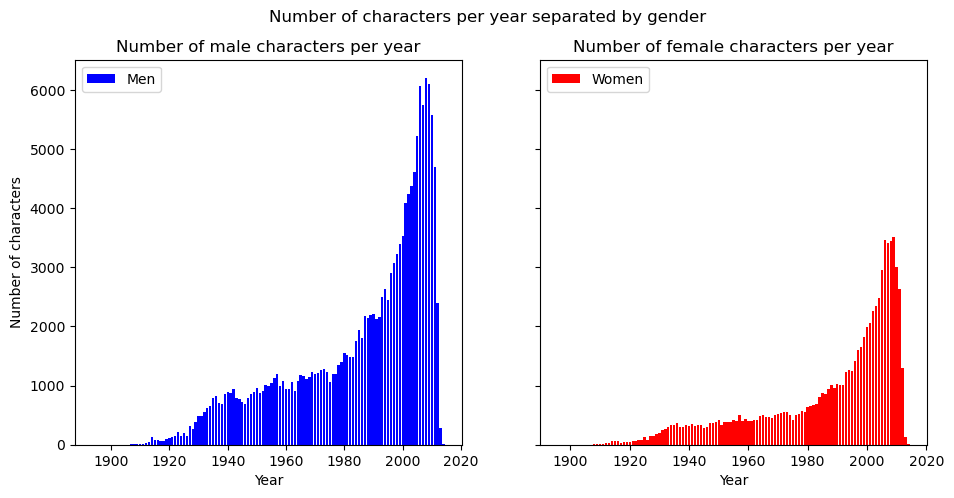

In [46]:
#Look at gender distribution over time
labels_men, counts_men = (np.sort(charadata_filtered[charadata_filtered['actor_gender'] == 'M']['release'].unique())) , charadata_filtered[charadata_filtered['actor_gender'] == 'M'].groupby(['release', 'actor_gender'])['actor_gender'].count()
labels_women, counts_women = (np.sort(charadata_filtered[charadata_filtered['actor_gender'] == 'F']['release'].unique())) , charadata_filtered[charadata_filtered['actor_gender'] == 'F'].groupby(['release', 'actor_gender'])['actor_gender'].count()
fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(11, 5), sharey = True)

ax0.bar(labels_men, counts_men,label='Men', color = 'blue')
ax1.bar(labels_women, counts_women,label='Women', color = 'red')
ax0.legend(loc='upper left')
ax1.legend(loc='upper left')


ax0.set_title('Number of male characters per year')
ax1.set_title('Number of female characters per year')

ax0.set_ylabel('Number of characters')
ax0.set_xlabel('Year')
ax1.set_xlabel('Year')

fig.suptitle('Number of characters per year separated by gender')

plt.show()

Above, we can observe that there is a constant increase for each category across time from year to year there are no huge drop nor inrease of the number of characters. Thus, we decide to create a column which corresponds to the decade in which the movie was released. Grouping movies by decade still allows a fine temporal resolution with an increased amount of data to perform the analysis on temporal evolution. We devide the dataset by decade as it seems to us that in such a period, the lifestyle remains constant. Indeed, we can assume that the purchasing power, population, movie habits and genre popularity remained stable in each decade. 

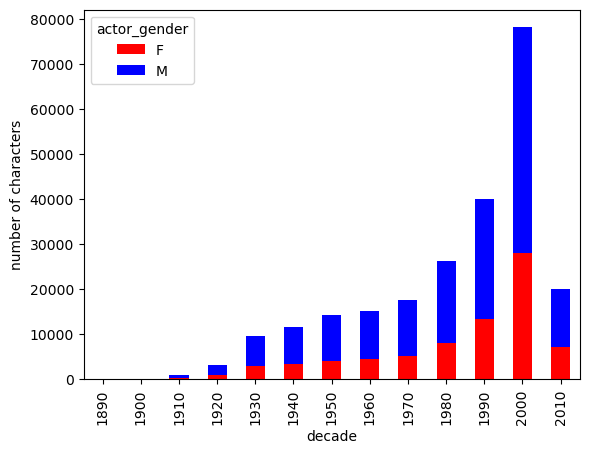

In [47]:
# Add column for decade distinction
charadata_filtered['decade'] = (charadata_filtered['release']//10)*10

# Indicate its decade of release and the year in the decade (ie. 0,1,2,3,4,5,6,7,8,9)
moviedata_filtered['decade'] = (moviedata_filtered['release']//10)*10
moviedata_filtered['year'] = moviedata_filtered['release']%10

#Look at gender distribution along time
charadata_filtered.groupby(['decade', 'actor_gender'])['actor_gender'].count().unstack().plot.bar(stacked=True, color = ['red', 'blue'])
plt.ylabel('number of characters')
plt.show()

We can notice that 1910 and 1920 have only a few movies. We can visualize further how many there are per decade. Plus, we know that the data is driven from Wikipedia in 2012 so the 2010 decade is not complete, as we decide to focus on the evolution by decade we may need to remove the last incomplete decade.

In [48]:
count_movies = charadata_filtered.groupby(['decade', 'actor_gender'])['actor_gender'].count()
count_movies

decade  actor_gender
1890    F                   2
        M                   3
1900    F                  16
        M                  35
1910    F                 379
        M                 637
1920    F                1024
        M                2068
1930    F                2979
        M                6641
1940    F                3367
        M                8210
1950    F                4069
        M               10150
1960    F                4501
        M               10746
1970    F                5216
        M               12390
1980    F                8083
        M               18044
1990    F               13264
        M               26686
2000    F               27929
        M               50183
2010    F                7057
        M               12976
Name: actor_gender, dtype: int64

We can see that the decades before 1910 contains too few values for any analysis. We can remove them.

In [49]:
moviedata_filtered = moviedata_filtered.loc[(moviedata_filtered['decade'] > 1910) & (moviedata_filtered['decade'] < 2010)]
charadata_filtered = charadata_filtered.loc[(charadata_filtered['decade'] > 1910) & (charadata_filtered['decade'] < 2010)]
print('We have now {} movies which contain all the necessary data for our analysis.'.format(len(moviedata_filtered)))
print('There are in average {:.2f} characters per movie.'.format(len(charadata_filtered)/len(moviedata_filtered)))

We have now 32249 movies which contain all the necessary data for our analysis.
There are in average 6.68 characters per movie.


After observing the number of men and women per decade to observe distribution, it makes sense to focus on relative distribution, as it is not easily readable in the above plots. Thus, we plotted both the proportion and ratio of men and women in the two visualizations below.

In [50]:
#Count male and female characters per decade across all movies
gender_count_perdecade = charadata_filtered.groupby('decade').apply(lambda x : pd.Series({'M' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'F' : x[x.actor_gender == 'F'].shape[0]}))
gender_count_perdecade['proportion_f'] = gender_count_perdecade.F * 100 / (gender_count_perdecade.M + gender_count_perdecade.F)
gender_count_perdecade.reset_index(inplace = True)
gender_count_perdecade.sort_values(by = "decade", inplace = True)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(go.Bar(name = 'Count of female characters', x = gender_count_perdecade['decade'], y = gender_count_perdecade['F']),
    secondary_y = False,
)
fig.add_trace(go.Scatter(name = 'Proportion of female characters', x=gender_count_perdecade['decade'], y=gender_count_perdecade['proportion_f']),
    secondary_y = True,
)


# Add figure title
fig.update_layout(
    title_text="<b>Count and proportion of female characters per decade",
    legend=dict(
        yanchor="bottom",
        y=.83,
        xanchor="right",
        x=0.45
    )
)

# Set x-axis title
fig.update_xaxes(title_text="Decade")

# Set y-axes titles
fig.update_yaxes(range=[0,60],title_text="Proportion of females [%]", secondary_y=True)
fig.update_yaxes(range=[0,30000], title_text="Count", secondary_y=False)

fig.show()


FIG_NAME = 'Count_proportion_general.svg'
pio.write_image(fig, file = JPEG_PATH + FIG_NAME, format="svg")

As one can see on the figure above, proportions of men in movies has been higher than the proportion of women in every decade from 1920 to 2000. As we are studying the evolution of women's representation, we also realized a statistical test to assess an eventual evolution in women's proportions in movies in every decade. To do so, we compare the average women's proportions for decade 1920 to 1950 (included) to the average proportions of women from 1960 to 2000. The results of this statistical test can be found below :  

In [51]:
#t-test to compare average women's proportions in movies compared to men, per decade 
t_stat, p_val = stats.ttest_ind(gender_count_perdecade.loc[gender_count_perdecade.index <= 1960]['proportion_f'], gender_count_perdecade.loc[gender_count_perdecade.index > 1960]['proportion_f'])
print("Results from the comparison of women's proportions for the periods 1920-1960 and 1970-2000 \nt_stat = {:.2f}, p_val = {:.2f}".format(t_stat, p_val))

Results from the comparison of women's proportions for the periods 1920-1960 and 1970-2000 
t_stat = nan, p_val = nan


Finally, as we observed the different ratios over time, it is interesting to also decompose the age distribution over decades, and try to see if we can observe an evolution within the general tendency. 

In [52]:
decades=np.sort(charadata_filtered['decade'].unique())

distrib = pd.DataFrame()

counts_w_overall = pd.Series(charadata_filtered[(charadata_filtered['actor_gender']=='F')]['actor_age'].value_counts() , name=("Overall_F"))
counts_m_overall = pd.Series(charadata_filtered[(charadata_filtered['actor_gender']=='M')]['actor_age'].value_counts() , name=("Overall_M"))
distrib = distrib.merge(counts_w_overall, how='outer', right_index=True, left_index=True)
distrib = distrib.merge(counts_m_overall, how='outer', right_index=True, left_index=True)

# male and female counts per decades
for decade in decades:
    counts_w = pd.Series(charadata_filtered[(charadata_filtered['actor_gender']=='F') & (charadata_filtered['decade']==decade)]['actor_age'].value_counts() , name=(str(decade) + "_F"))
    counts_m = pd.Series(charadata_filtered[(charadata_filtered['actor_gender']=='M') & (charadata_filtered['decade']==decade)]['actor_age'].value_counts() , name=(str(decade) + "_M"))
    distrib = distrib.merge(counts_w, how='outer', right_index=True, left_index=True)
    distrib = distrib.merge(counts_m, how='outer', right_index=True, left_index=True)


# Initialize figure
fig = go.Figure()

# Add Traces of male and female counts
for decade in decades:
    name_F = str(decade) + "_F"
    name_M = str(decade) + "_M"
    
    fig.add_trace(go.Bar(name="Male", x = distrib.index, y = distrib[name_M]))
    fig.add_trace(go.Bar(name="Female", x = distrib.index, y = distrib[name_F]))

fig.add_trace(go.Bar(name="Male", x = distrib.index, y = distrib["Overall_M"]))
fig.add_trace(go.Bar(name="Female", x = distrib.index, y = distrib["Overall_F"]))

#Show by default the 2000 decade 
for i in range(len(fig.data)):
    fig.data[i].visible = True if i > 17 else False

# Add dropdown list
fig.update_layout(
    yaxis_title = "Number of actor/actress",
    xaxis_title = "Age",
    title_text = "Distribution of age across genders during the 1920-2009 period",
    title_x = 0.45,

    updatemenus=[
        dict(
            active=0,
            buttons=list([ 
                dict(label="1920-2009",
                    method="update",
                    args=[{"visible": [False, False, False, False, False, False, False, False, 
                    False, False, False, False, False, False, False, False, False, False, True, True]},
                    {"title": "Distribution of age across genders during the 1920-2009 period"}]),
                dict(label="2000 decade",
                    method="update",
                    args=[{"visible": [False, False, False, False, False, False, False, False, 
                    False, False, False, False, False, False, False, False, True, True, False, False]},
                    {"title": 'Distribution of age across genders during the 2000 decade'}]),
                dict(label="1990 decade",
                    method="update",
                    args=[{"visible": [False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, True, True, False, False, False, False]},
                    {"title": 'Distribution of age across genders during the 1990 decade'}]),
                dict(label="1980 decade",
                    method="update",
                    args=[{"visible": [False, False, False, False, False, False, False, False, 
                    False, False, False, False, True, True, False, False, False, False, False, False]},
                    {"title": 'Distribution of age across genders during the 1980 decade'}]),
                dict(label="1970 decade",
                    method="update",
                    args=[{"visible": [False, False, False, False, False, False, False, False, 
                    False, False, True, True, False, False, False, False, False, False, False, False]},
                    {"title": 'Distribution of age across genders during the 1970 decade'}]),
                dict(label="1960 decade",
                    method="update",
                    args=[{"visible": [False, False, False, False, False, False, False, False, 
                    True, True, False, False, False, False, False, False, False, False, False, False]},
                    {"title": 'Distribution of age across genders during the 1960 decade'}]),
                dict(label="1950 decade",
                    method="update",
                    args=[{"visible": [False, False, False, False, False, False, True, True,
                    False, False, False, False, False, False, False, False, False, False, False, False]},
                    {"title": 'Distribution of age across genders during the 1950 decade'}]),
                dict(label="1940 decade",
                    method="update",
                    args=[{"visible": [False, False, False, False, True, True, False, False, 
                    False, False, False, False, False, False, False, False, False, False, False, False]},
                    {"title": 'Distribution of age across genders during the 1940 decade'}]),
                dict(label="1930 decade",
                    method="update",
                    args=[{"visible": [False, False, True, True, False, False, False, False,
                    False, False, False, False, False, False, False, False, False, False, False, False]},
                    {"title": 'Distribution of age across genders during the 1930 decade'}]),
                dict(label="1920 decade",
                    method="update",
                    args=[{"visible": [True, True, False, False, False, False, False, False, 
                    False, False, False, False, False, False, False, False, False, False, False, False]},
                    {"title": 'Distribution of age across genders during the 1920 decade'}])
            ]),
            x=0.70,
            y=1.15,
        ),
    ],

    legend=dict(
        yanchor="top",
        y=0.97,
        xanchor="right",
        x=0.99
    )
)
    
fig.update_layout(
    annotations=[
        dict(text='Choose your period:', x=0.40,xref='paper', yref='paper', y=1.12, showarrow=False)])

fig.show()

# Save to SVG for website
FIG_NAME = 'age_distribution.html'
pio.write_html(fig, file = HTML_PATH + FIG_NAME, auto_open=False)

No plot is shown on github, go check it on our [data story](https://pauldfepfl.github.io/siteadatest/jekyll/update/2022/12/21/datastory.html)

In [53]:
#t-test for evolution of mean actresses' age across decades
F_age_per_decade = charadata_filtered.groupby('decade').apply(lambda x : pd.Series({'age' : np.array(x['actor_age'])}))
decades=np.sort(charadata_filtered['decade'].unique())

for i in range(len(decades)-1) :
    F_age_1 = F_age_per_decade['age'].iloc[i]
    F_age_2 = F_age_per_decade['age'].iloc[i+1]
    t_stat, p_val = stats.ttest_ind(F_age_1, F_age_2)
    print("Decades : {} - {}".format(decades[i], decades[i+1]))
    if (p_val < 0.05) :
        print("\tAverage actresses age : {:.1f} ({}), {:.1f} ({}), significative difference with p_val - {:.3f}".format(np.mean(F_age_1), decades[i], np.mean(F_age_2), decades[i+1], p_val))
    else :
        print("\tAverage actresses age : {:.1f} ({}), {:.1f} ({})".format(np.mean(F_age_1), decades[i], np.mean(F_age_2), decades[i+1]))

print("\nDecades : {} - {}".format(decades[0], decades[8]))
t_stat, p_val = stats.ttest_ind(F_age_per_decade['age'].iloc[0], F_age_per_decade['age'].iloc[8])
print("\tAverage actresses age : {:.1f} ({}), {:.1f} ({}), significative difference with p_val - {:.3f}".format(np.mean(F_age_per_decade['age'].iloc[0]), decades[0], np.mean(F_age_per_decade['age'].iloc[8]), decades[8], p_val))

Decades : 1920 - 1930
	Average actresses age : 33.8 (1920), 36.8 (1930), significative difference with p_val - 0.000
Decades : 1930 - 1940
	Average actresses age : 36.8 (1930), 39.1 (1940), significative difference with p_val - 0.000
Decades : 1940 - 1950
	Average actresses age : 39.1 (1940), 39.0 (1950)
Decades : 1950 - 1960
	Average actresses age : 39.0 (1950), 39.5 (1960), significative difference with p_val - 0.004
Decades : 1960 - 1970
	Average actresses age : 39.5 (1960), 39.5 (1970)
Decades : 1970 - 1980
	Average actresses age : 39.5 (1970), 38.7 (1980), significative difference with p_val - 0.000
Decades : 1980 - 1990
	Average actresses age : 38.7 (1980), 38.7 (1990)
Decades : 1990 - 2000
	Average actresses age : 38.7 (1990), 38.4 (2000), significative difference with p_val - 0.000

Decades : 1920 - 2000
	Average actresses age : 33.8 (1920), 38.4 (2000), significative difference with p_val - 0.000


As one can see on the graph above, the average age for male actors is much higher than the average actresses' age. Furthermore, according to the statistical analysis, we can identify a evolutive trend for the average age of female actresses. Indeed, the average age start around 34 years in 1920 and increases up to 39 years in 1950. It stays more or less stable for a few decades, before slightly decreasing to 38 years in 2000. Overall (i.e., from 1920 to 2000) there is a very signifative increase in the average age of actresss, getting closer to the male actors' average age.

One could think about looking at the women's representation in the film industry depending on geographical location.

In [54]:
#input : takes a Series composed of lists of variable sizes 
#output : a 1D Series with the lists placed end to end
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

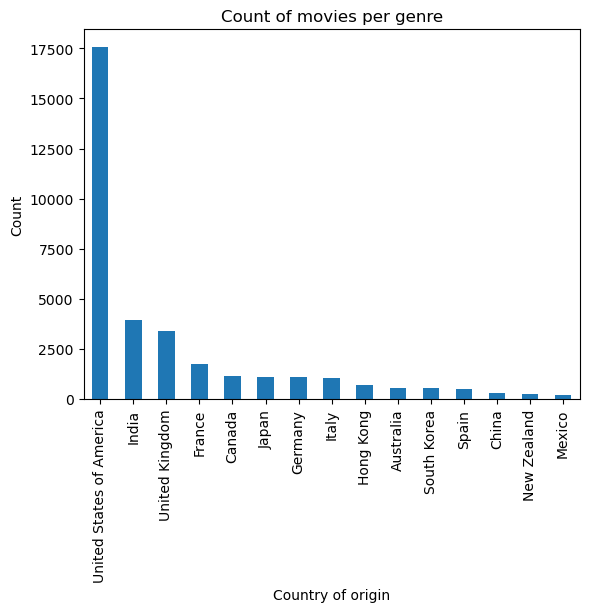

In [55]:
#counts the number of movies sharing the same origin
#Plot the countries which have more than a thousand movies
count_origin = to_1D(moviedata_filtered['countries']).value_counts()
count_origin = count_origin[count_origin>200] 

count_origin.plot(kind='bar')
plt.title('Count of movies per genre')
plt.xlabel('Country of origin')
plt.ylabel('Count')
plt.show()

We can see that a great part of the dataset is composed of american movies, we do not have enough data to take into account the geographical parameter.

In [56]:
"""DATA_FILTERED = "./Data_filtered/"

moviedata_filtered.to_csv(DATA_FILTERED + "moviedata_filtered.csv")
charadata_filtered.to_csv(DATA_FILTERED + "charadata_filtered.csv")
plots_filtered.to_csv(DATA_FILTERED + "plots_filtered.csv")"""

'DATA_FILTERED = "./Data_filtered/"\n\nmoviedata_filtered.to_csv(DATA_FILTERED + "moviedata_filtered.csv")\ncharadata_filtered.to_csv(DATA_FILTERED + "charadata_filtered.csv")\nplots_filtered.to_csv(DATA_FILTERED + "plots_filtered.csv")'

# PEUT COMMENCER ICI 

In [57]:
"""import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime #useful for date and time handling
import requests #used for getting data on the internet
from itertools import combinations  #used to create unique pairs from a list
import numpy as np
import plotly.express as px  #for plots with integrated cursor for better visualization
#from pandas_profiling import ProfileReport

DATA_FOLDER = "Data_filtered/"

#Create dataframes from the orignal dataset 
moviedata_filtered = pd.read_csv(DATA_FOLDER + 'moviedata_filtered.csv', index_col = 'wiki_id')
charadata_filtered = pd.read_csv(DATA_FOLDER + 'charadata_filtered.csv', index_col = 'wiki_id')
plots_filtered =  pd.read_csv(DATA_FOLDER + 'plots_filtered.csv', index_col = 'wiki_id')
plots = plots_filtered"""

'import pandas as pd\nimport matplotlib.pyplot as plt\nfrom datetime import datetime #useful for date and time handling\nimport requests #used for getting data on the internet\nfrom itertools import combinations  #used to create unique pairs from a list\nimport numpy as np\nimport plotly.express as px  #for plots with integrated cursor for better visualization\n#from pandas_profiling import ProfileReport\n\nDATA_FOLDER = "Data_filtered/"\n\n#Create dataframes from the orignal dataset \nmoviedata_filtered = pd.read_csv(DATA_FOLDER + \'moviedata_filtered.csv\', index_col = \'wiki_id\')\ncharadata_filtered = pd.read_csv(DATA_FOLDER + \'charadata_filtered.csv\', index_col = \'wiki_id\')\nplots_filtered =  pd.read_csv(DATA_FOLDER + \'plots_filtered.csv\', index_col = \'wiki_id\')\nplots = plots_filtered'

# Analysis on sample of the dataset

Up to this point, we analized the evolution of age and its distribution accross decade and between male nd female characters. In addition, we evaluated the presence of women looking at proportions and ratios accross time in the entire film industry (dataset).

To go further, we would like to analyzed the importance of women in the movie and how they participate to the plot by language analysis of the plot summaries. This would enable us to get a qualitative analysis and see whether there is an evolution of women's representation and relevance accross time.
Indeed, as we saw before, there could be very small evolution accross time or even none accross time. However this does not mean that nothing has changed. Indeed, even if the proportions of women did not vary, their importance in the movies coud have changed. This can be assessed throught language analysis. 

# Language analysis

In this section, we perform a language extraction using the Supplement: Stanford CoreNLP-processed summaries folder. This contains a series of xml files for each plot summary from the movies above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Following the article `Learning Latent Personas of Film Characters David Bamman, Brendan O'Connor, and Noah A. Smith ACL 2013, Sofia, Bulgaria, August 2013`,
we will work on the extraction following cc-processed dependencies from the typed dependency tuples produced by the parser which is collapsed dependencies with propagation of conjunct dependencies. We extract linguistic features such as agent verbs, patient verbs and attributes for each character to evaluate its importance and level of description in the movie. We can therefore evaluate the relevance of female vs male characters for each movie and its evolution accross decades. 

We extract the headwords which are in tuples with the name of each the character and devide them as follows:

• Agent verbs: Verbs for which the entity is an agent argument (nsubj or agent).

• Patient verbs: Verbs for which the entity is the patient, theme or other argument (dobj, nsubjpass, iobj, or any prepositional argument starting with prep_).

• Attributes: Adjectives and common noun words that relate to the mention as adjectival modifiers, noun-noun compounds, appositives, or copulas (nsubj or appos governors, or nsubj, appos, amod, nn dependents of an entity mention).

We will perform the language analysis on the minimal number of movies movies over all decade in the given dataset. We want to have the same and maximal amount of movies by decade to obtain enough results but at the same time to get consistency accross decade. As some decades do not have a sufficient number of movies, we will extract language analysis only from the relevant decade.

In [58]:
# set for reproducibility
rng = np.random.default_rng(7)

### Functions needed for Language Analysis

In [59]:
# The function counts the number of time a male or female character has been mentioned in the plot 
# Input: takes list to find character's name occurences from tuple produced by CoreNLP parser, the wiki_id of the movie,
#        dataframes of the movies' data and the characters' data,and string for the role type (i.e. agent, patient, attributes)

def count_chara_NLP(list_name_parser, movie_id, movie_data, movie_chara, character_data, type_):

    list_valid_type = ("patient", "agent", "attributes")
    if type_ not in list_valid_type:
        raise ValueError("Wrong role type, either: patient, agent, attributes")
        
    # For every element extracted from the tuples of the CoreNLP pipeline, add count in the data of the corresponding movie
    for elem in enumerate(list_name_parser):
        for i, chara in enumerate(movie_chara['character_name']):
            name_split = chara.split()
            for name_sep in name_split:
                if elem[1][0] == name_sep: # if name_sep.casefold() in map(str.casefold, list_name_parser):
                    # Count number of words associated to women or men depending of the role type_ analyzed
                    index = character_data[(character_data.wiki_id == movie_id) & (character_data['character_name'] == chara)].index[0]
                    col = character_data.columns.get_loc(type_)
                    character_data.iat[index, col] = character_data.iat[index, col] + [elem[1][1]]

                    # gender = ''.join(character_data.iloc[index]['actor_gender'].split())
                    if ('M' in movie_chara.iloc[i]['actor_gender']):
                        movie_data.loc[movie_id, str(type_ + '_man')] += 1
                    elif ('F' in movie_chara.iloc[i]['actor_gender']):
                        movie_data.loc[movie_id, str(type_ + '_woman')] += 1


# It opens the xml file for each movie in our sample dataset
# Fill the lists of all agent verbs, patient verbs and attributes pressent in the collapsed-ccprocessed-dependencies subpart of the xml file 
# Fill the characteritics columns of all characters for each movie
def extract_xml (movie_data, character_data):

    for movie_id in movie_data.index :
        with gzip.open(NLP_FOLDER + str(movie_id) +'.xml.gz', 'r') as f:
            data = f.read()
        cc_processed = SoupStrainer("collapsed-ccprocessed-dependencies")
        soup = BeautifulSoup(data, "xml", parse_only=cc_processed)
    
        # get the text for one element of the tuples extracted by the parser depending of the list of elements extract
        agent = [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'nsubj'})]
        agent += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'agent'})]
        agent = [[re.sub(r"[^a-zA-Z0-9]","",i[0]),re.sub(r"[^a-zA-Z0-9]","",i[1])] for i in agent] # filter out non alphabetical or numerical characters found

        patient = [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'dobj'})]
        patient += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'nsubjpass'})]
        patient += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'iobj'})]
        patient += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep', type = lambda value: value and value.startswith('prep_'))]
        patient = [[re.sub(r"[^a-zA-Z0-9]","",i[0]),re.sub(r"[^a-zA-Z0-9]","",i[1])] for i in patient]

        #attributes = [[a.find('governor').get_text(), a.find('dependent').get_text()] for a in soup.find_all('dep',{'type':'nsubj'})]
        attributes = [[a.find('governor').get_text(), a.find('dependent').get_text()] for a in soup.find_all('dep',{'type':'appos'})]
        #attributes += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'nsubj'})]
        attributes += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'appos'})]
        attributes += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'amod'})]
        attributes += [[a.find('dependent').get_text(), a.find('governor').get_text()] for a in soup.find_all('dep',{'type':'nn'})]
        attributes = [[re.sub(r"[^a-zA-Z0-9]","",i[0]),re.sub(r"[^a-zA-Z0-9]","",i[1])] for i in attributes]
        

        movie_chara = character_data[character_data.wiki_id == movie_id][['character_name','actor_gender']].reset_index().copy()
        movie_chara = movie_chara[~movie_chara.isnull().any(axis=1)]
        
        count_chara_NLP(agent, movie_id, movie_data, movie_chara, character_data, "agent")
        count_chara_NLP(patient, movie_id, movie_data, movie_chara, character_data, "patient")
        count_chara_NLP(attributes, movie_id, movie_data, movie_chara, character_data, "attributes")

In [60]:
# The function selects a random sample of size n per decade in the dataset to perform the language analysis.
# Creates a column for each word type and for each gender 
# Apply the language analysis on the sample of movies and store the list of words per character

def langage_analysis(movie_, characters_, decades, size_):

    # Reset index to select a random sample n of movies using the wiki_id
    movie_.reset_index(inplace=True)
    characters_.reset_index(inplace=True)

    # To extract male and female characteritics we need the character names to identify the relevant words in the xml files. 
    # Therefore we remove all characters without name from character.
    characters_2 = characters_[characters_["character_name"].notna()]

    # Select the random sample of the dataset
    sample = []
    for decade in decades:
        char_movie = characters_2[characters_2['decade'] == decade]
        print(char_movie.wiki_id.nunique())
        sample = np.append(sample, rng.choice(char_movie.wiki_id.unique(), size = size_, replace = False))

    characters_2 = characters_2[characters_2["wiki_id"].isin(sample)]
    movie_2 = movie_[movie_["wiki_id"].isin(sample)]
    movie_2 = movie_2.set_index('wiki_id')

    #Create and initialise colums of the dataframe to count agent verbs, patient verbs and attributes for each character and each movie

    characters_2['agent'] = [[]]*len(characters_2)
    characters_2['patient'] = [[]]*len(characters_2)
    characters_2['attributes'] = [[]]*len(characters_2)

    # Creates the colums to store the language analysis in the movie dataset 
    movie_2 = movie_2.assign(agent_woman = lambda x : 0)
    movie_2 = movie_2.assign(patient_woman = lambda x : 0)
    movie_2 = movie_2.assign(attributes_woman = lambda x : 0)
    movie_2 = movie_2.assign(agent_man = lambda x : 0)
    movie_2 = movie_2.assign(patient_man = lambda x : 0)
    movie_2 = movie_2.assign(attributes_man = lambda x : 0)

    #resets indexes for extract_xml function 
    characters_2.reset_index(drop = True, inplace = True)

    extract_xml(movie_2,characters_2)

    return (movie_2,characters_2)

In order to get representative results in the film industry while reducing time consumption we decided to perform the language analysis on the same amount of movies per decade for consistency. We thus randomly select 900 movies for each decade in the previous dataset.

In [61]:
#select only caharacters for which we have both the gender and the charcter name to allow langage analysis
charadata_sample = charadata_filtered[charadata_filtered["character_name"].notna()]
intersection = moviedata_filtered.index.intersection(charadata_sample.index)
intersection = plots.index.intersection(intersection)

charadata_sample = charadata_sample.reset_index()
movie_sample = moviedata_filtered.loc[intersection, :'year']
movie_sample = movie_sample.reset_index()

In [62]:
decades = np.arange(1940,2001,10)

size = 900

rdsample_la, rdsample_la_charadata = langage_analysis(movie_sample, charadata_sample, decades, size)

935
1334
1305
1575
2519
3997
7594


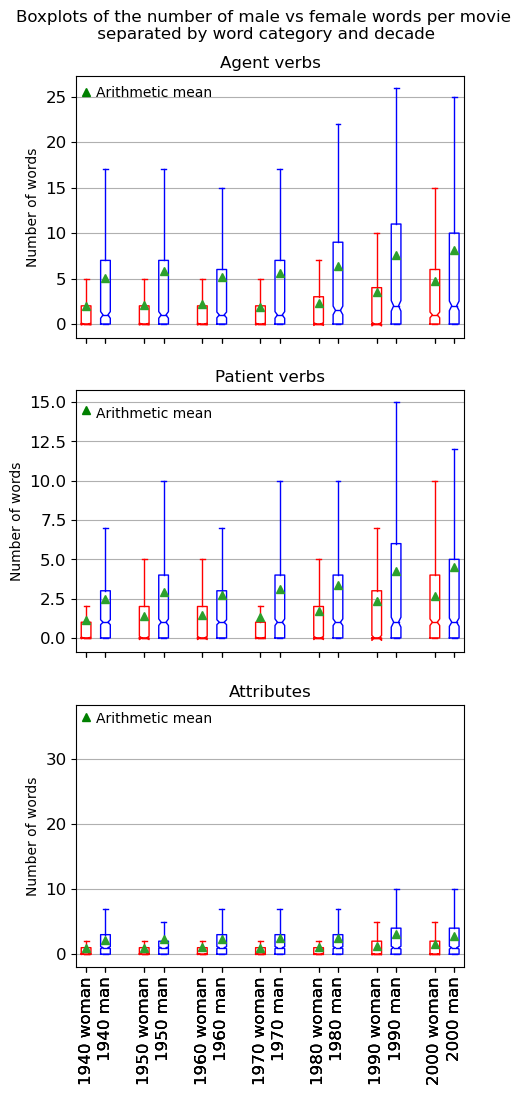

In [63]:
#Plot the average number of men vs women words for each word category separated by decade
rdsample_la_grp = rdsample_la.groupby(['decade'])

fig, (ax0,ax1,ax2) = plt.subplots(nrows=3,figsize=(5, 11), sharex = True, sharey = False)

woman_pos = np.arange(1,len(decades)*3, 3)
man_pos = np.arange(2,len(decades)*3, 3)

rdsample_la_grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['agent_woman'],showfliers=False, showmeans = True, ax=ax0,
positions = woman_pos,color='r', notch =True)
rdsample_la_grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['agent_man'],showfliers=False, showmeans = True,ax=ax0,
positions = man_pos,color='b', notch =True)
rdsample_la_grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['patient_woman'],showfliers=False, showmeans = True, ax=ax1,
positions = woman_pos,color='r', notch =True)
rdsample_la_grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['patient_man'],showfliers=False, showmeans = True,ax=ax1,
positions = man_pos,color='b', notch =True)
rdsample_la_grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['attributes_woman'],showfliers=False, showmeans = True, ax=ax2,
positions = woman_pos,color='r', notch =True)
rdsample_la_grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['attributes_man'],showfliers=False, showmeans = True,ax=ax2,
positions = man_pos,color='b', notch =True)

#set the x ticks labels to visualize decade and gender
x_labels = [""] * (4 * len(decades))
for i, dec in enumerate(decades):
    x_labels += [str(dec) + " woman"]
for i, dec in enumerate(decades):
    x_labels += [str(dec) + " man"]
ax2.set_xticklabels(x_labels)

#add legend for arithmetic mean
ax0.plot(1,25.5,"g^")
ax0.text(1.5,25,"Arithmetic mean")
ax1.plot(1,14.5,"g^")
ax1.text(1.5,14,"Arithmetic mean")
ax2.plot(1,36.5,"g^")
ax2.text(1.5,35.5,"Arithmetic mean")

ax0.set_title('Agent verbs')
ax1.set_title('Patient verbs')
ax2.set_title('Attributes')

ax0.set_ylabel('Number of words')
ax1.set_ylabel('Number of words')
ax2.set_ylabel('Number of words')

fig.suptitle('Boxplots of the number of male vs female words per movie\n separated by word category and decade')
fig.subplots_adjust(top=0.92)

for ax in [ax0,ax1,ax2]:
    ax.grid(axis = 'x')

plt.show()

Here, we cannot assess any constant increase over time in the number of descriptive words for both male and female characters. However, we can assess that male characters are much more developped and described with agent and patient verbs as well as attributes for all decade compared to female characters. 

Now, we can visualize the repartition and evolution of the proportion of word used to described female characters compared to male over time.

In [64]:
#Function which analyses character information such as age and gender and compare men and women characteristics
def count_chara(genre_data,character_genre):
    character_genre = character_genre.groupby('wiki_id')
    nb_characters = character_genre['actor_gender'].count()
    genre_data['nb_characters'] = nb_characters
    genre_data['nb_women'] = character_genre['actor_gender'].apply(lambda x: x[x == 'F'].count())
    genre_data['nb_men'] = character_genre['actor_gender'].apply(lambda x: x[x == 'M'].count())
    genre_data['ratio_gender'] = genre_data['nb_women'] / genre_data['nb_men']
    genre_data['average_age_men'] = character_genre.apply(lambda x: x['actor_age'].loc[x['actor_gender'] == 'M'].mean())
    genre_data['average_age_women'] = character_genre.apply(lambda x: x['actor_age'].loc[x['actor_gender'] == 'F'].mean())

In [65]:
count_chara(rdsample_la, rdsample_la_charadata)

In [66]:
rdsample_grp = rdsample_la.groupby(['decade']) 

decades = np.arange(1940,2001,10)

# Initialize figure
fig = go.Figure()

fig.update_xaxes(title_text="Decade")

fig.update_yaxes(range=[0,60])


# Add Traces of female proportion 
fig.add_trace(
    go.Scatter(name="Agent verbs", x = decades, y = rdsample_grp.apply(lambda x : (100 * (x['agent_woman']/x['nb_women'])/(x['agent_man']/x['nb_men'] + x['agent_woman']/x['nb_women'])).mean()),
                line=dict(width=2, color='blue'), marker=dict(color='blue'))
)

fig.add_trace(
    go.Scatter(name="Patient verbs", x = decades, y = rdsample_grp.apply(lambda x : (100 * (x['patient_woman']/x['nb_women'])/(x['patient_man']/x['nb_men'] + x['patient_woman']/x['nb_women'])).mean()),
                line=dict(width=2, color='tomato'), marker=dict(color='tomato'))
)

fig.add_trace(
    go.Scatter(name="Attributes", x = decades, y = rdsample_grp.apply(lambda x : (100 * (x['attributes_woman']/x['nb_women'])/(x['attributes_man']/x['nb_men'] + x['attributes_woman']/x['nb_women'])).mean()),
                line=dict(width=2, color='green'), marker=dict(color='green'))
)



#Show by default all types of words (agent/patient verbs + attributes)
for i in range(len(fig.data)):
    fig.data[i].visible = True 


# Add dropdown list
fig.update_layout(
    yaxis_title = "Average proportion of words per women[%]",
    xaxis_title = "Decade",
    title_text = "<b>Average percentage of allocation of words to women per movie",
    legend=dict( 
        yanchor="bottom",
        y=0.03,
        xanchor="right",
        x=0.99
    )
)

fig.show()

FIG_NAME = 'word_proportion_general.html'

pio.write_html(fig, file = HTML_PATH + FIG_NAME, auto_open=False)

In [67]:
rdsample_la.head()

,index,movie_name,release,countries,genres,decade,year,agent_woman,patient_woman,attributes_woman,agent_man,patient_man,attributes_man,nb_characters,nb_women,nb_men,ratio_gender,average_age_men,average_age_women
wiki_id,,,,,,,,,,,,,,,,,,,
2462689,5,Meet John Doe,1941,[United States of America],"[Romantic comedy, Media Satire, Romance Film, ...",1940,1,3,4,1,6,1,13,2,1,1,1.000,39.0,33.0
2940516,8,Ghost In The Noonday Sun,1973,[United Kingdom],"[Comedy, Parody]",1970,3,0,0,0,0,0,0,1,0,1,0.000,37.0,NaN
13455076,18,A Merry Mixup,1957,[United States of America],"[Comedy, Black-and-white, Short Film]",1950,7,0,0,0,0,0,0,1,0,1,0.000,59.0,NaN
447194,21,Samson and Delilah,1949,[United States of America],"[History, Drama, Adventure, Romance Film, Action]",1940,9,4,5,1,6,16,4,13,5,8,0.625,47.0,40.8
18549958,22,"Love, Mary",1985,[United States of America],"[Drama, Biopic [feature]]",1980,5,4,2,0,0,0,0,1,1,0,inf,NaN,23.0


We can notice a very small increase of the proportion of words for women overtime between 1970s and 2000s. This can result from a higher amount of descriptive words for woman or an higher amount of woman playing in the movies. Another possibility is that the amount of words for male character decreased.

# WordCloud

Following the language analysis, we can now use the extracted agent and patient verbs and attributes to obtain a qualitative visualize of the word use for women and men accross time.

All wordclouds are stored in the folder WordCloud followed by appropriate folders by analysis.

### Functions needed for wordclouds

In [68]:
# Create a wordcloud for every combination of decade, word type and gender 

def wordcloud_decade(charadata, decades, PATH, sample_pop, mask=None):
   
    # Create a dataframe that concatenates the lists of all words of the same decade and for the same gender for each  word type 
    list_word = pd.DataFrame()
    list_word['agent'] = charadata.groupby(['decade', 'actor_gender'])['agent'].agg(sum)
    list_word['patient'] = charadata.groupby(['decade', 'actor_gender'])['patient'].agg(sum)
    list_word['attribute'] = charadata.groupby(['decade', 'actor_gender'])['attributes'].agg(sum)
    
    gender = ['F','M']
    type = ['agent', 'patient', 'attribute' ]

    for dec in decades:
        for gen in gender:

            # Select mask if not given
            if sample_pop:

                if gen == 'F':
                    mask = np.array(Image.open("Mask/Woman.jpg"))
                else:
                    mask = np.array(Image.open("Mask/Man.jpg"))

            #select the text color 
            if gen == 'F':
                color_txt = 'red'
            else:
                color_txt = 'blue'
            
            for ty in type:
                
                # Create a string from each word in the list 
                text = " ".join(str(word) for word in list_word.loc[dec,gen][ty])

                # Casefolding
                text = text.lower() 

                # Creating a spacy object for lemmatization
                nlp = spacy.load('en_core_web_sm')
                text_sp = nlp(text)

                # Lemmatization
                words = []
                words = words + [token.lemma_ for token in text_sp]

                # Create a string from each lemmatized word in the list 
                text_wordcloud = ' '.join(word for word in words)

                # Generate Wordcloud
                wc = WordCloud(color_func=lambda *args, **kwargs: color_txt, background_color="white", max_words=200, mask=mask,
                        stopwords=STOPWORDS, max_font_size=40, random_state=3, collocations=False).generate(text_wordcloud)

                # store to file
                wc.to_file(os.path.join(PATH, f"{dec}_"+f"{gen}_"+f"{ty}.png"))  


In [69]:
# Create a wordcloud for every combination of word type gender over the entire era 
def wordcloud_era(charadata,decades,PATH,sample_pop, mask=None):   
    
    list_word = pd.DataFrame()
    list_word['agent'] = charadata.groupby(['decade', 'actor_gender'])['agent'].agg(sum)
    list_word['patient'] = charadata.groupby(['decade', 'actor_gender'])['patient'].agg(sum)
    list_word['attribute'] = charadata.groupby(['decade', 'actor_gender'])['attributes'].agg(sum)
    
    gender = ['F','M']
    type = ['agent', 'patient', 'attribute' ]
    
    for gen in gender:

        # Select mask if not given
        if sample_pop:

            if gen == 'F':
                mask = np.array(Image.open("Mask/Woman.jpg"))
            else:
                mask = np.array(Image.open("Mask/Man.jpg"))
                
        #select the text color 
        if gen == 'F':
            color_txt = 'red'
        else:
            color_txt = 'blue'
        
        for ty in type:
            
            list_temp = []

            #Concatenate the lists of word fro all decade
            for dec in decades:
                list_temp = list_temp + list_word.loc[dec,gen][ty]
            
            # Create a string from each word in the list for the entire era
            text = " ".join(str(word) for word in list_temp)
            
            # Casefolding
            text = text.lower() 

            # Creating a spacy object for lemmatization
            nlp = spacy.load('en_core_web_sm')
            text_sp = nlp(text)

            # Lemmatization
            words = []
            words = words + [token.lemma_ for token in text_sp]

            # Create a string from each lemmatized word in the list 
            text_wordcloud = ' '.join(word for word in words)

            # Generate Wordcloud
            wc = WordCloud(color_func=lambda *args, **kwargs: color_txt, background_color="white", max_words=100, mask=mask,
                    stopwords=STOPWORDS, max_font_size=40, random_state=3,height=100,width=100,collocations=False).generate(text_wordcloud)

            # store to file
            wc.to_file(os.path.join(PATH, "Full_"+f"{gen}_"+f"{ty}.png"))

In [70]:
#Create output directories
os.makedirs("WordCloud/Sample/",exist_ok=True)

path_sample = "WordCloud/Sample/"

In [71]:
decades = np.arange(1940,2001,10)


wordcloud_decade(rdsample_la_charadata,decades,path_sample, sample_pop=True)
wordcloud_era(rdsample_la_charadata,decades,path_sample,sample_pop=True)

# ANALYSIS BY GENRE

Following the observed trends and results previously obtained, we would like to know wether these apply to distinct genres within the film industry. Analysis accross genres allows to determine the most popular ones which implies a superior impact on the society. Repeating steps previously done such as age and proportion of male vs female characters over time for distinct genres would allow to highligths effects common to the whole industry. Due to the variety of genres in the dataset, it would be better to focus on a lesser extent of genres with a sufficient count for relevance and that are as distinct as possible to study similarity.

In [72]:
#input : takes a Series composed of lists of variavble sizes 
#output : a 1D Series with the lists placed end to end

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

Text(0, 0.5, 'Count')

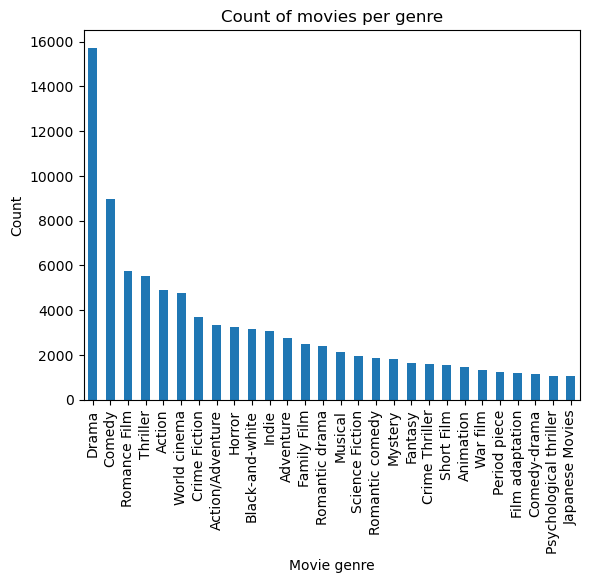

In [73]:
#counts the number of movies tagged with each genre 
#Plot the genres that contain more than a thousand movies
#moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(eval)
count_genres = to_1D(moviedata_filtered['genres']).value_counts()
count_genres = count_genres[count_genres>1000] 

count_genres.plot(kind='bar')
plt.title('Count of movies per genre')
plt.xlabel('Movie genre')
plt.ylabel('Count')

We decided to keep the top 10 genres with the highest movie counts to have a sufficient effect size for our following analysis. We notice that the genre World cinema is in the top 10. We decide to remove this genre as it represents all non-american movies while our dataset contains a great part of movies coming from the United States and that it is a movie genre per se.

In [74]:
selected = count_genres[:10].index #we take the 10 genres with the highest counts of movies
selected = selected.drop(['World cinema']) 
identification_genre = moviedata_filtered[['genres']].copy() #temporary dataframe for genre identification for each movie

In [75]:
#for each genre checks if the movie is part of a top 10 genre
for i in selected:
    identification_genre[str(i)] = identification_genre['genres'].apply(lambda x: 1 if i in x else 0) # for each genre chekcs if the movie is part of the genre

From these top 10 genres, we want to extract a combination of three genres that provides a sufficient count of movies that are listed in only one of the three genres, that have similar counts, and that have the lowest ratio of removed movies belonging to several genres of the three. This allows the extraction of a combination of three isolated genres. Indeed, this will result in three genres as independent as possible from each other with relative importance in the film industry due to a high movie count. It allows us to compare movies that belong to only one of the three different and independent genres to study if our following analysis shows the same results accross the film industry.

In [76]:
triplets = list((combinations(selected,3)))   # create all triplets possible for the selected genres
count_per_genre = np.zeros((len(triplets), 3))  # count number of movies for each genre for each triplet 
count_unique_per_genre = np.zeros((len(triplets), 3)) # count number of movies for each genre for each triplet which are not shared by the other genres of the triplet

for i, triplet in enumerate(triplets) :
    for j, genre in enumerate(triplet) :
        count_per_genre[i,j] = identification_genre.loc[:,genre].sum()  
        others = list(triplet)
        others.remove(genre)
        count_unique_per_genre[i,j] = len(identification_genre[(identification_genre[genre] == 1) \
            & (identification_genre[others[0]] != 1)\
            & (identification_genre[others[1]] != 1)])

In [77]:
#Criteria to select the genre triplet
loss_genres = (count_per_genre - count_unique_per_genre) / count_per_genre  
mean_loss = pd.Series(np.mean(loss_genres, axis=1), index = triplets) # mean per triplet of proportion of loss of number of shared movies    
genre_loss_std = pd.Series(np.std(loss_genres, axis=1), index = triplets) # std of loss of counts of movies in each triplet 
mean_count = pd.Series(np.mean(count_unique_per_genre, axis=1), index = triplets) # mean of counts of movies per triplet

In [78]:
evaluation_df = pd.concat([mean_loss,genre_loss_std,mean_count],axis=1)
evaluation_df.columns = ['mean count loss', 'std loss', 'mean counts']
fig = px.scatter(evaluation_df , x = 'mean count loss', y = 'std loss', color = 'mean counts', title="Scatter plot evaluating independence for genres in each triplet", width=716, height=750, hover_name = list(mean_count.index))
fig.show()

We can see that the triplet which looses few movie, in which the differences in count in the triplets is minimal and which has an overall higher mean of counts of movies than is neighbors in the triplet is Romance Film, Action and Horror. 

In [79]:
#Check that each movie belongs to only one of the genres present in the triplet
selected_genres = ['Romance Film', 'Action', 'Horror']

for genre in selected_genres:
    moviedata_filtered[genre] = moviedata_filtered['genres'].apply(lambda x: 1 if genre in x else 0)

moviedata_filtered['unique_genre'] = moviedata_filtered.loc[:,selected_genres].sum(axis = 1)

In [80]:
#Drop movies that belong to more than one genre in the triplet or none of them
unique_genre = moviedata_filtered.drop(moviedata_filtered[moviedata_filtered['unique_genre'] != 1].index)

<AxesSubplot:>

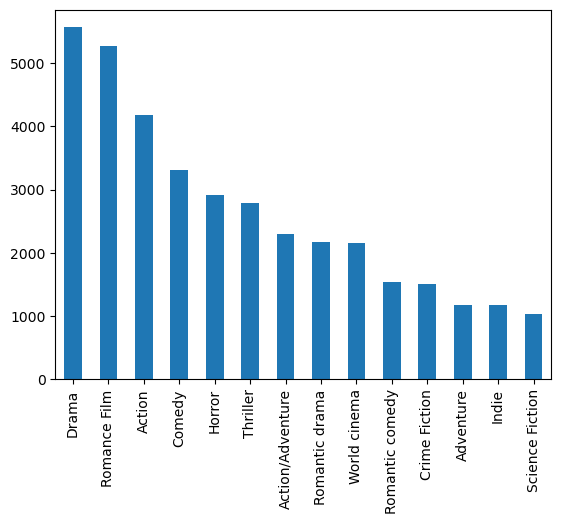

In [81]:
#Plot the distribution of count of movies that belong to one genre in the triplets
count_selected = to_1D(unique_genre['genres']).value_counts()

count_selected = count_selected[count_selected>1000]

count_selected.plot(kind='bar')

We notice that comedy and Drama have a high count of movies. This means that the movies filtered at this point from the dataset belong in addition to one of the triplet genre to Drama or Comedy. This higlights the fact that these genre are more general than others.

In [82]:
unique_genre.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
20663735,Narasimham,2000,[India],"[Drama, Bollywood, Action, Musical]",2000,0,0,1,0,1
5272176,End Game,2006,"[United States of America, Germany, Canada]","[Drama, Action/Adventure, Action, Thriller]",2000,6,0,1,0,1
1952976,Dark Water,2005,[United States of America],"[Horror, Drama, Thriller]",2000,5,0,0,1,1
2462689,Meet John Doe,1941,[United States of America],"[Romantic comedy, Media Satire, Romance Film, ...",1940,1,1,0,0,1
1335380,Exodus,1960,[United States of America],"[War film, Epic, Film adaptation, Political dr...",1960,0,0,1,0,1


In [83]:
#Select the genre of the triplet to which the movie belongs
for genre in selected_genres:
    unique_genre['genres'] = unique_genre['genres'].apply(lambda x: genre if genre in x else x)

In [84]:
unique_genre.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
20663735,Narasimham,2000,[India],Action,2000,0,0,1,0,1
5272176,End Game,2006,"[United States of America, Germany, Canada]",Action,2000,6,0,1,0,1
1952976,Dark Water,2005,[United States of America],Horror,2000,5,0,0,1,1
2462689,Meet John Doe,1941,[United States of America],Romance Film,1940,1,1,0,0,1
1335380,Exodus,1960,[United States of America],Action,1960,0,0,1,0,1


In [85]:
print('Looking at these three specific genres we can study the evolution of women represention in {} movies'.format(len(unique_genre)))

Looking at these three specific genres we can study the evolution of women represention in 12362 movies


In [86]:
#Split the previous dataframe in three distinct ones for each genre to allow parallel analysis
horror = unique_genre.loc[unique_genre['genres'] == 'Horror'].copy()
action = unique_genre.loc[unique_genre['genres'] == 'Action'].copy()
romance = unique_genre.loc[unique_genre['genres'] == 'Romance Film'].copy()

In [87]:
#counts the amount of revenues provided in each genre
horror_count = len(horror.index)
action_count = len(action.index)
romance_count = len(romance.index)
print('We have now {} horror movies extracted.'.format(horror_count))
print('We have now {} horror movies extracted.'.format(action_count))
print('We have now {} horror movies extracted.'.format(romance_count))

We have now 2906 horror movies extracted.
We have now 4179 horror movies extracted.
We have now 5277 horror movies extracted.


Now we will look at the evolution of the number of movies per decade for each of the three genres selected.

Text(0, 0.5, 'Number of movies')

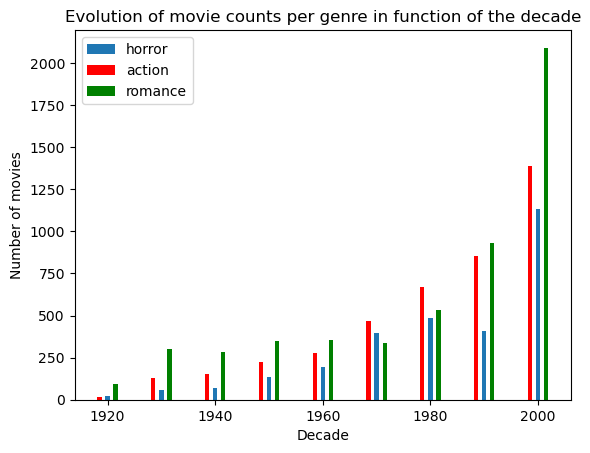

In [88]:
#Plot the evolution of the movie count per genre and per decade 
plt.bar(horror['decade'].sort_values().unique(), horror.groupby(['decade'])['release'].count(), label = 'horror')
plt.bar(action['decade'].sort_values().unique() - 1.5, action.groupby(['decade'])['release'].count(), color='red', label = 'action')
plt.bar(romance['decade'].sort_values().unique() + 1.5, romance.groupby(['decade'])['release'].count(), color= 'green', label = 'romance')

plt.legend(loc = 'upper left')
plt.title('Evolution of movie counts per genre in function of the decade')
plt.xlabel('Decade')
plt.ylabel('Number of movies')

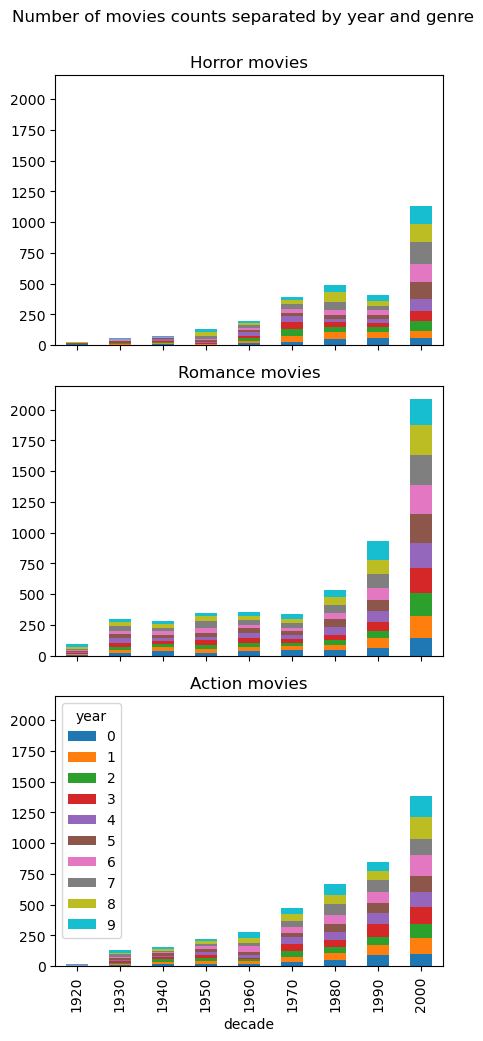

In [89]:
#Subplot the evolution of the movie per decade for each genre with the detailed count per year
fig = plt.figure(figsize=(5, 11))
gs = fig.add_gridspec(3, hspace=0.15)
axs = gs.subplots(sharex=True, sharey=True)

horror.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[0], stacked=True)
romance.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[1], stacked=True)
action.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[2], stacked=True)

axs[0].get_legend().remove()
axs[1].get_legend().remove()

axs[0].title.set_text('Horror movies')
axs[1].title.set_text('Romance movies')
axs[2].title.set_text('Action movies')

fig.suptitle('Number of movies counts separated by year and genre')
fig.subplots_adjust(top=0.92)

##### Analysis on character's list

In [90]:
#Select characters according to movies belonging to one of the three genres
horror_charadata = charadata_filtered.loc[horror.index.intersection(charadata_filtered.index)]
action_charadata = charadata_filtered.loc[action.index.intersection(charadata_filtered.index)]
romance_charadata = charadata_filtered.loc[romance.index.intersection(charadata_filtered.index)]
horror_charadata.head()

,release,character_name,actor_gender,actor_name,actor_age,decade
wiki_id,,,,,,
1952976,2005,Mediator,F,Linda Emond,46.0,2000
1952976,2005,Dahlia,F,Jennifer Connelly,34.0,2000
1952976,2005,Mr. Murray,M,John C. Reilly,40.0,2000
1952976,2005,Jeff Platzer,M,Tim Roth,44.0,2000
1952976,2005,Kyle Williams,M,Dougray Scott,39.0,2000


First we wish to have a look at the numbers and proportions of male and female characters across all action movies :
There are 25376 male characters, corresponding to 76.51% of all characters
There are 7790 female characters, corresponding to 23.49% of all characters
First we wish to have a look at the numbers and proportions of male and female characters across all horror movies :
There are 11146 male characters, corresponding to 64.07% of all characters
There are 6250 female characters, corresponding to 35.93% of all characters
First we wish to have a look at the numbers and proportions of male and female characters across all romance movies :
There are 23896 male characters, corresponding to 59.80% of all characters
There are 16062 female characters, corresponding to 40.20% of all characters


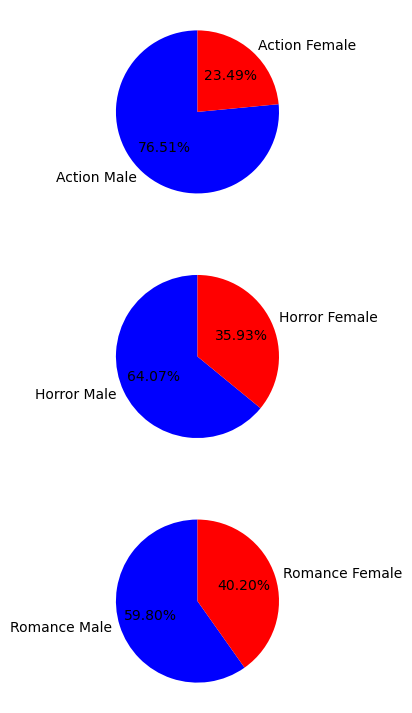

In [91]:
#Assess women's presence accross all charaters from every movie genre
M_action_count = action_charadata[action_charadata.actor_gender == 'M'].shape[0]
F_action_count = action_charadata[action_charadata.actor_gender == 'F'].shape[0]

M_action_proportion = M_action_count / (M_action_count + F_action_count)
F_action_proportion = F_action_count / (M_action_count + F_action_count)

M_horror_count = horror_charadata[horror_charadata.actor_gender == 'M'].shape[0]
F_horror_count = horror_charadata[horror_charadata.actor_gender == 'F'].shape[0]

M_horror_proportion = M_horror_count / (M_horror_count + F_horror_count)
F_horror_proportion = F_horror_count / (M_horror_count + F_horror_count)

M_romance_count = romance_charadata[romance_charadata.actor_gender == 'M'].shape[0]
F_romance_count = romance_charadata[romance_charadata.actor_gender == 'F'].shape[0]

M_romance_proportion = M_romance_count / (M_romance_count + F_romance_count)
F_romance_proportion = F_romance_count / (M_romance_count + F_romance_count)

print("First we wish to have a look at the numbers and proportions of male and female characters across all action movies :")
print("There are {} male characters, corresponding to {:.2f}% of all characters".format(M_action_count, M_action_proportion*100))
print("There are {} female characters, corresponding to {:.2f}% of all characters".format(F_action_count, F_action_proportion*100))

print("First we wish to have a look at the numbers and proportions of male and female characters across all horror movies :")
print("There are {} male characters, corresponding to {:.2f}% of all characters".format(M_horror_count, M_horror_proportion*100))
print("There are {} female characters, corresponding to {:.2f}% of all characters".format(F_horror_count, F_horror_proportion*100))

print("First we wish to have a look at the numbers and proportions of male and female characters across all romance movies :")
print("There are {} male characters, corresponding to {:.2f}% of all characters".format(M_romance_count, M_romance_proportion*100))
print("There are {} female characters, corresponding to {:.2f}% of all characters".format(F_romance_count, F_romance_proportion*100))



fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(5, 9), sharex = True)

ax0.pie([M_action_proportion, F_action_proportion], labels = ["Action Male", "Action Female"], startangle = 90, autopct = "%0.2f%%",colors=['blue','red'])
ax1.pie([M_horror_proportion, F_horror_proportion], labels = ["Horror Male", "Horror Female"], startangle = 90, autopct = "%0.2f%%",colors=['blue','red'])
ax2.pie([M_romance_proportion, F_romance_proportion], labels = ["Romance Male", "Romance Female"], startangle = 90, autopct = "%0.2f%%",colors=['blue','red'])

plt.show()

#save plots
piechart(M_action_proportion, F_action_proportion,'action_pie.svg')
piechart(M_horror_proportion, F_horror_proportion,'horror_pie.svg')
piechart(M_romance_proportion, F_romance_proportion,'romance_pie.svg')

C:\Users\monoy\AppData\Local\Temp\ipykernel_12560\1450809677.py:40: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



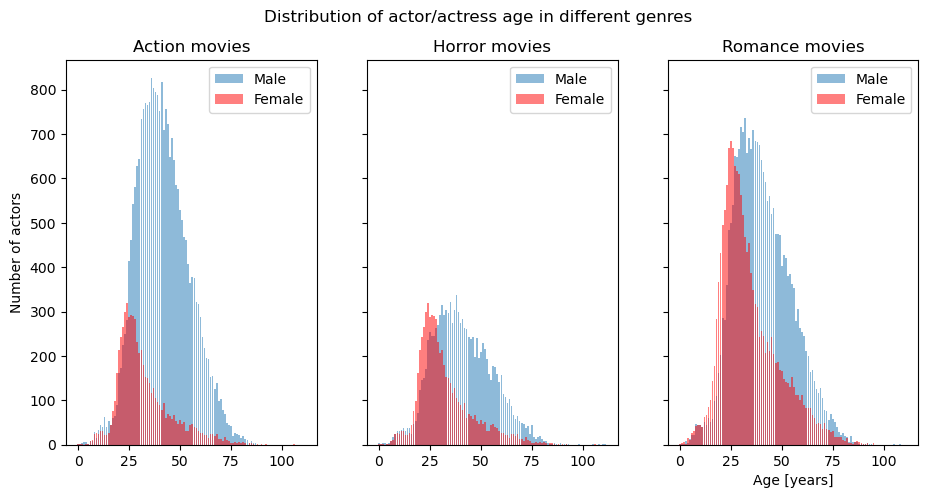

In [92]:
#Plot age distribution across movie genre

M_horror = horror_charadata[horror_charadata['actor_gender']=='M']
F_horror = horror_charadata[horror_charadata['actor_gender']=='F']
Mc_horror = M_horror['actor_age'].value_counts()
Fc_horror = F_horror['actor_age'].value_counts()

M_action = action_charadata[action_charadata['actor_gender']=='M']
F_action = action_charadata[action_charadata['actor_gender']=='F']
Mc_action = M_action['actor_age'].value_counts()
Fc_action = F_action['actor_age'].value_counts()

M_romance = romance_charadata[romance_charadata['actor_gender']=='M']
F_romance = romance_charadata[romance_charadata['actor_gender']=='F']
Mc_romance = M_romance['actor_age'].value_counts()
Fc_romance = F_romance['actor_age'].value_counts()

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,figsize=(11, 5), sharex = True, sharey = True)

ax0.bar(np.sort(Mc_action.index),Mc_action[np.sort(Mc_action.index)],alpha=0.5,label='Male')
ax0.bar(np.sort(Fc_horror.index),Fc_horror[np.sort(Fc_horror.index)],alpha=0.5,label='Female', color = 'red')
ax0.set_title("Action movies")
ax0.set_ylabel('Number of actors')
ax0.legend(loc='upper right')

ax1.bar(np.sort(Mc_horror.index),Mc_horror[np.sort(Mc_horror.index)],alpha=0.5,label='Male')
ax1.bar(np.sort(Fc_horror.index),Fc_horror[np.sort(Fc_horror.index)],alpha=0.5,label='Female', color = 'red')
ax1.set_title("Horror movies")
ax1.legend(loc='upper right')

ax2.bar(np.sort(Mc_romance.index),Mc_romance[np.sort(Mc_romance.index)],alpha=0.5,label='Male')
ax2.bar(np.sort(Fc_romance.index),Fc_romance[np.sort(Fc_romance.index)],alpha=0.5,label='Female', color = 'red')
ax2.set_title("Romance movies")
ax2.set_xlabel('Age [years]')
ax2.legend(loc='upper right')

fig.suptitle('Distribution of actor/actress age in different genres')


fig.show()

In [93]:
count_chara(horror, horror_charadata)
count_chara(action, action_charadata)
count_chara(romance, romance_charadata)

In [94]:
# The function computes the means of the age of men and women actors as well as the standard deviations for each decade 

def stats_age_decade(genre_charadata):

    genre_age = genre_charadata.groupby(['decade'])
    mean_age_men = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'M']['actor_age'].mean())
    std_age_men = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'M']['actor_age'].std())
    mean_age_women = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'F']['actor_age'].mean())
    std_age_women = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'F']['actor_age'].std())

    return mean_age_men, std_age_men, mean_age_women, std_age_women

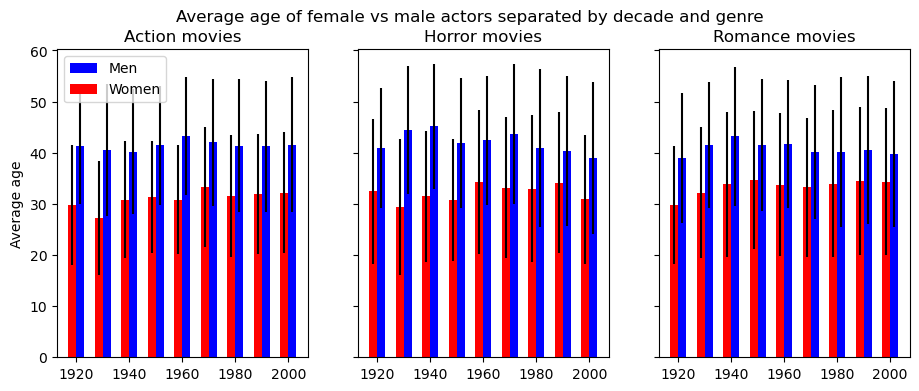

In [95]:
# Compute some stats for the three selected genres and plot them by decade for each genre
action_age = stats_age_decade(action_charadata)
horror_age = stats_age_decade(horror_charadata)
romance_age = stats_age_decade(romance_charadata)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3,figsize=(11, 4), sharex = True, sharey = True)
width = 3

ax0.bar(action_age[0].index + width/2, action_age[0],width, yerr = action_age[1],label='Men', color = 'blue')
ax0.bar(action_age[2].index - width/2, action_age[2],width, yerr = action_age[3],  label='Women', color = 'red')
ax1.bar(horror_age[0].index + width/2, horror_age[0],width, yerr = horror_age[1],label='Men', color = 'blue')
ax1.bar(horror_age[2].index - width/2, horror_age[2],width, yerr = horror_age[3],  label='Women', color = 'red')
ax2.bar(romance_age[0].index + width/2, romance_age[0],width, yerr = romance_age[1],label='Men', color = 'blue')
ax2.bar(romance_age[2].index - width/2, romance_age[2],width, yerr = romance_age[3],  label='Women', color = 'red')


ax0.set_title('Action movies')
ax1.set_title('Horror movies')
ax2.set_title('Romance movies')

ax0.set_ylabel('Average age')
ax0.legend(loc='upper left')

fig.suptitle('Average age of female vs male actors separated by decade and genre')
fig.subplots_adjust()


FIG_NAME = 'age_genre.svg'

fig.savefig(JPEG_PATH + FIG_NAME, format='svg', dpi=1200)

In [96]:
#Count male and female characters per decade across all movies
gender_count_action = action_charadata.groupby('decade').apply(lambda x : pd.Series({'M' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'F' : x[x.actor_gender == 'F'].shape[0]}))
gender_count_action['proportion_f'] = gender_count_action.F * 100 / (gender_count_action.M + gender_count_action.F)
gender_count_action.reset_index(inplace = True)
gender_count_action.sort_values(by = "decade", inplace = True)

gender_count_horror = horror_charadata.groupby('decade').apply(lambda x : pd.Series({'M' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'F' : x[x.actor_gender == 'F'].shape[0]}))
gender_count_horror['proportion_f'] = gender_count_horror.F * 100 / (gender_count_horror.M + gender_count_horror.F)
gender_count_horror.reset_index(inplace = True)
gender_count_horror.sort_values(by = "decade", inplace = True)

gender_count_romance = romance_charadata.groupby('decade').apply(lambda x : pd.Series({'M' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'F' : x[x.actor_gender == 'F'].shape[0]}))
gender_count_romance['proportion_f'] = gender_count_romance.F * 100 / (gender_count_romance.M + gender_count_romance.F)
gender_count_romance.reset_index(inplace = True)
gender_count_romance.sort_values(by = "decade", inplace = True)

# Create figure with secondary y-axis
fig = make_subplots(rows=1, cols=3, shared_xaxes = True, shared_yaxes = "all", horizontal_spacing = 0.02,
                    specs=[[{"secondary_y": True,}, {"secondary_y": True,}, {"secondary_y": True,}]],
                    subplot_titles = ["Action movies", "Horror movies", "Romance movies"])

blue, red = px.colors.qualitative.Plotly[0], px.colors.qualitative.Plotly[1]

# Add traces
fig.add_trace(go.Bar(name = 'Count', x = gender_count_action['decade'], y = gender_count_action['F'], marker_color = blue),
    secondary_y = False, row = 1, col = 1
)
fig.add_trace(go.Scatter(name = 'Proportion', x=gender_count_action['decade'], y=gender_count_action['proportion_f'], line=dict(width=2, color=red), marker=dict(color=red)),
    secondary_y = True, row = 1, col = 1
)
fig.add_trace(go.Bar(name = 'Count of female characters', x = gender_count_horror['decade'], y = gender_count_horror['F'],showlegend=False, marker_color = blue),
    secondary_y = False, row = 1, col = 2   
)
fig.add_trace(go.Scatter(name = 'Proportion of female characters', x=gender_count_horror['decade'], y=gender_count_horror['proportion_f'],showlegend=False, line=dict(width=2, color=red), marker=dict(color=red)),
    secondary_y = True, row = 1, col = 2  
)
fig.add_trace(go.Bar(name = 'Count of female characters', x = gender_count_romance['decade'], y = gender_count_romance['F'],showlegend=False, marker_color = blue),
    secondary_y = False, row = 1, col = 3   
)
fig.add_trace(go.Scatter(name = 'Proportion of female characters', x=gender_count_romance['decade'], y=gender_count_romance['proportion_f'],showlegend=False, line=dict(width=2, color=red), marker=dict(color=red)),
    secondary_y = True, row = 1, col = 3  
)
# Add figure title
fig.update_layout(
    title_text="<b>Count and proportion of female characters per decade",
    legend=dict(
        yanchor="bottom",
        y=.83,
        xanchor="right",
        x=0.215
    )
)

# Set x-axis title
fig.update_xaxes(title_text="Decade")

# Set y-axes titles
fig.update_yaxes(range = [0,10000], row = 1, secondary_y = False)
fig.update_yaxes(title_text = "Count", secondary_y = False, row = 1, col = 1)
fig.update_yaxes(range = [0,50], row = 1, secondary_y = True)
fig.update_yaxes(title_text = "Proportion of females [%]", secondary_y = True, row = 1, col = 3)


fig.show()


FIG_NAME = 'Count_proportion_genres.svg'
pio.write_image(fig, file = JPEG_PATH + FIG_NAME, format = "svg")

In [97]:
# select 175 random movies per decade from 1970 to process a langage analysis on the plot summaries of each movie genre 
rng = np.random.default_rng(7)

# We do not have sufficent horror movies to perform the analysis before 1970
decades = np.arange(1970,2001,10)

size = 175

horror_la, horror_la_charadata = langage_analysis(horror, horror_charadata, decades, size)
action_la, action_la_charadata = langage_analysis(action,action_charadata,decades,size)
romance_la, romance_la_charadata = langage_analysis(romance,romance_charadata,decades,size)

179
249
252
696
294
475
655
1091
218
410
783
1661


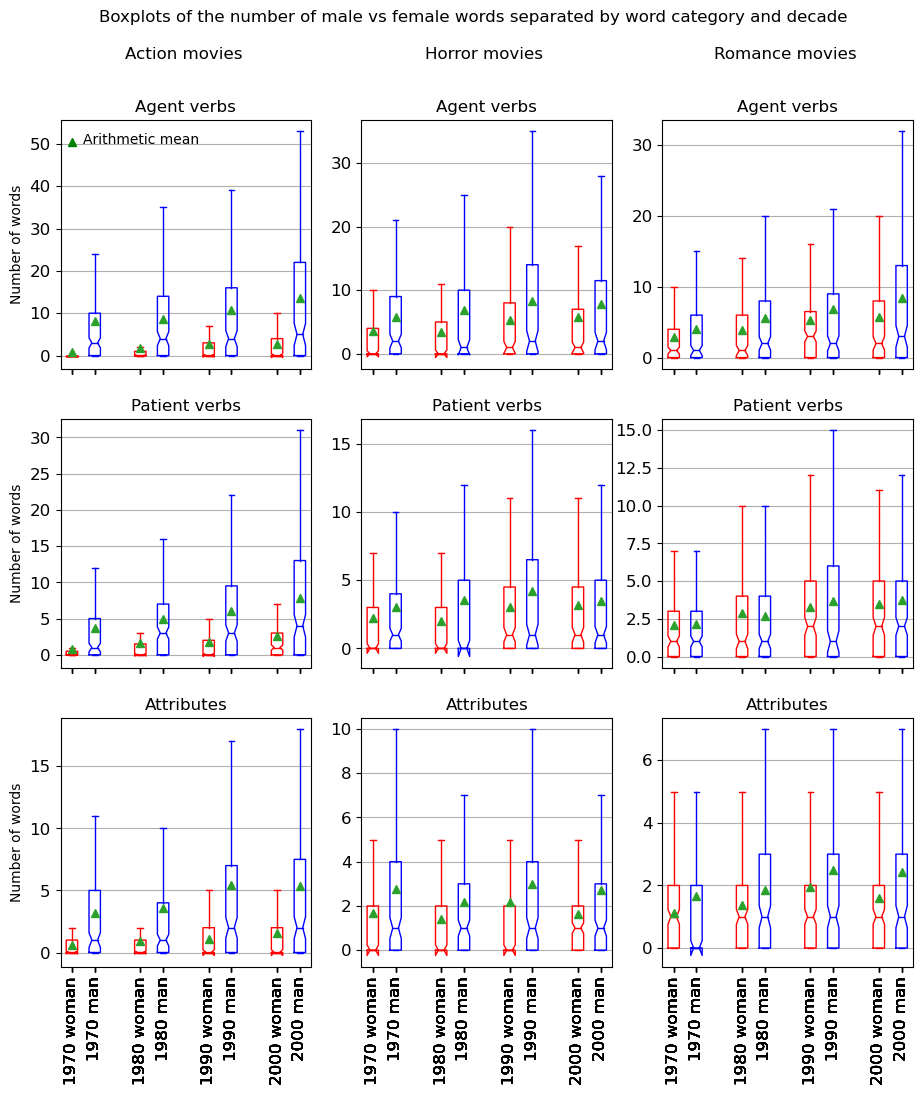

In [98]:
#Plot the average number of men vs women words for each word category separated by decade
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(11, 11), sharex = True, sharey = False)

for i, type in enumerate([action_la,horror_la,romance_la]):
    grp = type.groupby(['decade'])

    woman_pos = np.arange(1,len(decades)*3, 3)
    man_pos = np.arange(2,len(decades)*3, 3)

    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['agent_woman'],showfliers=False, showmeans = True, ax=axs[0][i],
    positions = woman_pos,color='r', notch =True)
    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['agent_man'],showfliers=False, showmeans = True,ax=axs[0][i],
    positions = man_pos,color='b', notch =True)
    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['patient_woman'],showfliers=False, showmeans = True, ax=axs[1][i],
    positions = woman_pos,color='r', notch =True)
    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['patient_man'],showfliers=False, showmeans = True,ax=axs[1][i],
    positions = man_pos,color='b', notch =True)
    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['attributes_woman'],showfliers=False, showmeans = True, ax=axs[2][i],
    positions = woman_pos,color='r', notch =True)
    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['attributes_man'],showfliers=False, showmeans = True,ax=axs[2][i],
    positions = man_pos,color='b', notch =True)


#set the x ticks labels to visualize decade and gender and the titles of each subplot
x_labels = []
for i,type in enumerate(["Action","Horror","Romance"]):

    axs[0][i].set_title(str(type) + ' movies \n\n\nAgent verbs')
    axs[1][i].set_title('Patient verbs')
    axs[2][i].set_title('Attributes')
    axs[i][0].set_ylabel('Number of words')
    x_labels += [""] * (4 * len(decades))
    for i, dec in enumerate(decades):
        x_labels += [str(dec) + " woman"]
    for i, dec in enumerate(decades):
        x_labels += [str(dec) + " man"]
    


axs[2][2].set_xticklabels(x_labels)

#add legend for arithmetic mean
axs[0][0].plot(1,50.5,"g^")
axs[0][0].text(1.5,50,"Arithmetic mean")

for axs_ in axs:
    for ax in axs_:
        ax.grid(axis = 'x')

fig.suptitle('Boxplots of the number of male vs female words separated by word category and decade')

plt.show()

In [99]:
action_grp = action_la.groupby(['decade']) 
horror_grp = horror_la.groupby(['decade']) 
romance_grp = romance_la.groupby(['decade']) 
decades = np.arange(1970,2001,10)


# Initialize figure
fig = make_subplots(rows=1, cols=3, shared_xaxes = True, shared_yaxes = True, subplot_titles = ["Action movies", "Horror movies", "Romance movies"], horizontal_spacing = 0.02,)

fig.update_xaxes(title_text="Decade", row=1, col=1)
fig.update_xaxes(title_text="Decade", row=1, col=2)
fig.update_xaxes(title_text="Decade", row=1, col=3)

fig.update_yaxes(range=[0,60])

fig.add_trace(
    go.Scatter(name="Agent verbs", x = decades, y = action_grp.apply(lambda x : (100 * (x['agent_woman']/x['nb_women'])/(x['agent_man']/x['nb_men'] + x['agent_woman']/x['nb_women'])).mean()),
                line=dict(width=2, color='blue'), marker=dict(color='blue')), row = 1, col = 1   
)

fig.add_trace(
    go.Scatter(name="Agent verbs", x = decades, y = horror_grp.apply(lambda x : (100 * (x['agent_woman']/x['nb_women'])/(x['agent_man']/x['nb_men'] + x['agent_woman']/x['nb_women'])).mean()),
                showlegend=False, line=dict(width=2, color='blue'), marker=dict(color='blue')), row = 1, col = 2 
)

fig.add_trace(
    go.Scatter(name="Agent verbs", x = decades, y = romance_grp.apply(lambda x : (100 * (x['agent_woman']/x['nb_women'])/(x['agent_man']/x['nb_men'] + x['agent_woman']/x['nb_women'])).mean()),
                showlegend=False, line=dict(width=2, color='blue'), marker=dict(color='blue')), row = 1, col = 3
)

fig.add_trace(
    go.Scatter(name="Patient verbs", x = decades, y = action_grp.apply(lambda x : (100 * (x['patient_woman']/x['nb_women'])/(x['patient_man']/x['nb_men'] + x['patient_woman']/x['nb_women'])).mean()),
                line=dict(width=2, color='tomato'), marker=dict(color='tomato')), row = 1, col = 1
)

fig.add_trace(
    go.Scatter(name="Patient verbs", x = decades, y = horror_grp.apply(lambda x : (100 * (x['patient_woman']/x['nb_women'])/(x['patient_man']/x['nb_men'] + x['patient_woman']/x['nb_women'])).mean()),
                showlegend=False, line=dict(width=2, color='tomato'), marker=dict(color='tomato')), row = 1, col = 2
)

fig.add_trace(
    go.Scatter(name="Patient verbs", x = decades, y = romance_grp.apply(lambda x : (100 * (x['patient_woman']/x['nb_women'])/(x['patient_man']/x['nb_men'] + x['patient_woman']/x['nb_women'])).mean()),
                showlegend=False, line=dict(width=2, color='tomato'), marker=dict(color='tomato')), row = 1, col = 3
)

fig.add_trace(
    go.Scatter(name="Attributes", x = decades, y = action_grp.apply(lambda x : (100 * (x['attributes_woman']/x['nb_women'])/(x['attributes_man']/x['nb_men'] + x['attributes_woman']/x['nb_women'])).mean()),
                line=dict(width=2, color='green'), marker=dict(color='green')), row = 1, col = 1
)

fig.add_trace(
    go.Scatter(name="Attributes", x = decades, y = horror_grp.apply(lambda x : (100 * (x['attributes_woman']/x['nb_women'])/(x['attributes_man']/x['nb_men'] + x['attributes_woman']/x['nb_women'])).mean()),
                showlegend=False, line=dict(width=2, color='green'), marker=dict(color='green')), row = 1, col = 2
)

fig.add_trace(
    go.Scatter(name="Attributes", x = decades, y = romance_grp.apply(lambda x : (100 * (x['attributes_woman']/x['nb_women'])/(x['attributes_man']/x['nb_men'] + x['attributes_woman']/x['nb_women'])).mean()),
                showlegend=False, line=dict(width=2, color='green'), marker=dict(color='green')), row = 1, col = 3
)


# Add dropdown list
fig.update_layout(
    yaxis_title = "Average proportion of words per women[%]",
    xaxis_title = "Decade",
    title_text = "<b>Average percentage of allocation of words to women per movie",

    legend=dict( 
        yanchor="bottom",
        y=0.04,
        xanchor="right",
        x=0.98
    )
)

fig.show()

FIG_NAME = 'word_proportion_genres.html'

pio.write_html(fig, file = HTML_PATH + FIG_NAME, auto_open=False)

### WordCloud by movie genre 

In [100]:
#Load the masks 
mask_Action = np.array(Image.open("Mask/Action.png"))
mask_Horror = np.array(Image.open("Mask/Horror.png"))
mask_Romance = np.array(Image.open("Mask/Romance.png"))

#Create output directories
os.makedirs("WordCloud/Genre/Action/", exist_ok = True)
os.makedirs("WordCloud/Genre/Horror/", exist_ok = True)
os.makedirs("WordCloud/Genre/Romance/", exist_ok = True)


path_action = "WordCloud/Genre/Action/"
path_horror = "WordCloud/Genre/Horror/"
path_romance = "WordCloud/Genre/Romance/"

In [101]:
decades = np.arange(1970,2001,10)

wordcloud_decade(action_la_charadata, decades, path_action, False, mask_Action)
wordcloud_era(action_la_charadata, decades, path_action, False, mask_Action)

wordcloud_decade(horror_la_charadata, decades, path_horror, False, mask_Horror)
wordcloud_era(horror_la_charadata, decades, path_horror, False, mask_Horror)

wordcloud_decade(romance_la_charadata, decades, path_romance, False, mask_Romance)
wordcloud_era(romance_la_charadata, decades, path_romance, False, mask_Romance)

# Study case: Some geographical insight

At this point, we have seen that our original results on the overall population vary between genres. Those variation are visible in age, proportions and language analysis according to the genre. 

In consequence, knowing that the representation and evolution of women is not conserved in the film industry, we wonder whether the trends also depend on the location where the movie originated. To do so, we can make a case study out of two major references of the film industry: Hollywood and Bollywood which are the most represented in the dataset.

We can choose to focus on american (USA) and indian movies and look at the possible differences as both countries of origins have very different cultures.

Text(0.5, 0.98, 'Number of indian vs american movies by decade')

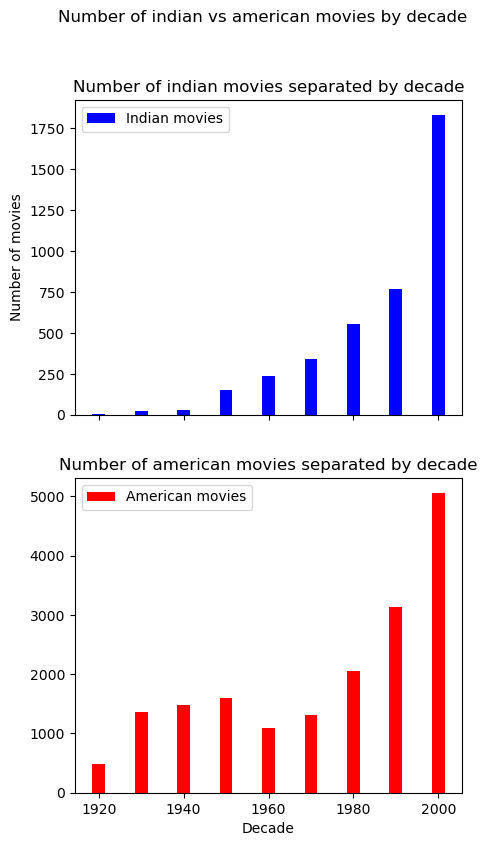

In [102]:
indian_movies = moviedata_filtered[moviedata_filtered.apply(lambda x : 'India' in x.countries, axis = 1)].copy()
american_movies = moviedata_filtered[moviedata_filtered.apply(lambda x : 'United States of America' in x.countries, axis = 1)].copy()

fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(5, 9), sharex = True)

ax0.bar(indian_movies['decade'].sort_values().unique(), indian_movies.groupby('decade')['movie_name'].count(), 3,label='Indian movies', color = 'blue')
ax1.bar(american_movies['decade'].sort_values().unique(), american_movies.groupby('decade')['movie_name'].count(), 3,label='American movies', color = 'red')
ax0.legend(loc='upper left')
ax1.legend(loc='upper left')


ax0.set_title('Number of indian movies separated by decade')
ax1.set_title('Number of american movies separated by decade')

ax0.set_ylabel('Number of movies')
ax1.set_xlabel('Decade')

fig.suptitle('Number of indian vs american movies by decade')

In [103]:
indian_movies.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
20663735,Narasimham,2000,[India],"[Drama, Bollywood, Action, Musical]",2000,0,0,1,0,1
8388648,Nee Sneham,2002,[India],[Drama],2000,2,0,0,0,0
10644072,Bhagwan Dada,1986,[India],[],1980,6,0,0,0,0
33269085,Kehtaa Hai Dil Baar Baar,2002,"[United States of America, India]","[Romance Film, Comedy film]",2000,2,1,0,0,1
2254491,Mr. & Mrs. '55,1955,[India],"[Bollywood, Romance Film, Comedy, Musical]",1950,5,1,0,0,1


From here we can continue our analysis and compare how women are represented in both geographical with the same metrics used before, for example :
- proportion of women
- average age of female actors
- linguistic analysis of the polts 


First we wish to have a look at the numbers and proportions of male and female characters across all movies :
There are 13976 Indian male characters, corresponding to 65.39% of all characters
There are 7398 Indian female characters, corresponding to 34.61% of all characters
First we wish to have a look at the numbers and proportions of male and female characters across all movies :
There are 94906 American male characters, corresponding to 68.09% of all characters
There are 44476 American female characters, corresponding to 31.91% of all characters


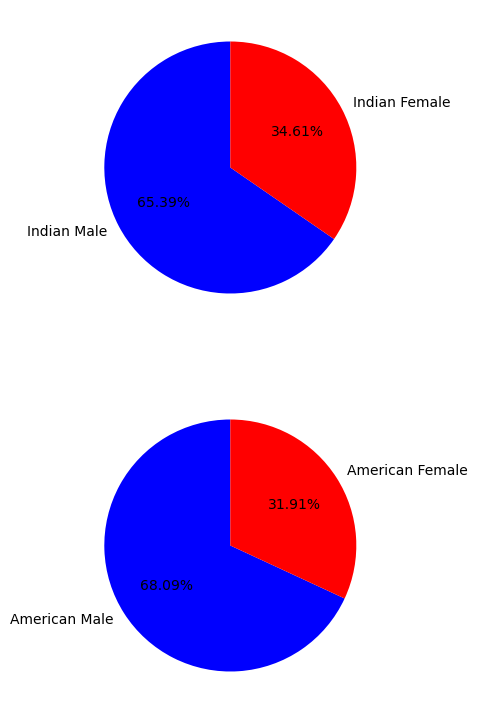

In [104]:
indian_charadata = charadata_filtered[charadata_filtered.index.isin(indian_movies.index)]
american_charadata = charadata_filtered[charadata_filtered.index.isin(american_movies.index)]


#Assess women's presence accross all charaters from every movies
M_ind_count = indian_charadata[indian_charadata.actor_gender == 'M'].shape[0]
F_ind_count = indian_charadata[indian_charadata.actor_gender == 'F'].shape[0]

M_ind_proportion = M_ind_count / (M_ind_count + F_ind_count)
F_ind_proportion = F_ind_count / (M_ind_count + F_ind_count)

M_us_count = american_charadata[american_charadata.actor_gender == 'M'].shape[0]
F_us_count = american_charadata[american_charadata.actor_gender == 'F'].shape[0]

M_us_proportion = M_us_count / (M_us_count + F_us_count)
F_us_proportion = F_us_count / (M_us_count + F_us_count)

print("First we wish to have a look at the numbers and proportions of male and female characters across all movies :")
print("There are {} Indian male characters, corresponding to {:.2f}% of all characters".format(M_ind_count, M_ind_proportion*100))
print("There are {} Indian female characters, corresponding to {:.2f}% of all characters".format(F_ind_count, F_ind_proportion*100))

print("First we wish to have a look at the numbers and proportions of male and female characters across all movies :")
print("There are {} American male characters, corresponding to {:.2f}% of all characters".format(M_us_count, M_us_proportion*100))
print("There are {} American female characters, corresponding to {:.2f}% of all characters".format(F_us_count, F_us_proportion*100))

fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(5, 9), sharex = True)

ax0.pie([M_ind_proportion, F_ind_proportion], labels = ["Indian Male", "Indian Female"], startangle = 90, autopct = "%0.2f%%",colors=['blue','red'])
ax1.pie([M_us_proportion, F_us_proportion], labels = ["American Male", "American Female"], startangle = 90, autopct = "%0.2f%%",colors=['blue','red'])

plt.show()

piechart(M_ind_proportion, F_ind_proportion,'indian_pie.svg')
piechart(M_us_proportion, F_us_proportion,'us_pie.svg')

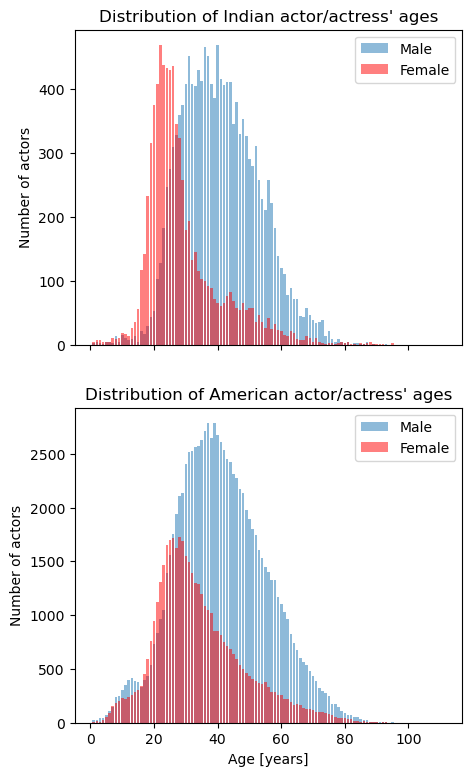

In [105]:
#Plot age distribution across gender

charadata_filtered = charadata_filtered.loc[(charadata_filtered['actor_age']>0) & (charadata_filtered['actor_age']<120)]
indian_charadata = charadata_filtered[charadata_filtered.index.isin(indian_movies.index)].copy()
american_charadata = charadata_filtered[charadata_filtered.index.isin(american_movies.index)].copy()

M_ind = indian_charadata[indian_charadata['actor_gender']=='M']
F_ind = indian_charadata[indian_charadata['actor_gender']=='F']
Mc_ind = M_ind['actor_age'].value_counts()
Fc_ind = F_ind['actor_age'].value_counts()

M_us = american_charadata[american_charadata['actor_gender']=='M']
F_us = american_charadata[american_charadata['actor_gender']=='F']
Mc_us = M_us['actor_age'].value_counts()
Fc_us = F_us['actor_age'].value_counts()

fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(5, 9), sharex = True)

ax0.bar(np.sort(Mc_ind.index),Mc_ind[np.sort(Mc_ind.index)],alpha=0.5,label='Male')
ax0.bar(np.sort(Fc_ind.index),Fc_ind[np.sort(Fc_ind.index)],alpha=0.5,label='Female', color = 'red')
ax0.set_title("Distribution of Indian actor/actress' ages")
ax0.set_ylabel('Number of actors')
ax0.legend(loc='upper right')

ax1.bar(np.sort(Mc_us.index),Mc_us[np.sort(Mc_us.index)],alpha=0.5,label='Male')
ax1.bar(np.sort(Fc_us.index),Fc_us[np.sort(Fc_us.index)],alpha=0.5,label='Female', color = 'red')
ax1.set_title("Distribution of American actor/actress' ages")
ax1.set_xlabel('Age [years]')
ax1.set_ylabel('Number of actors')
ax1.legend(loc='upper right')

plt.show()

In [106]:
indian_movies.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
20663735,Narasimham,2000,[India],"[Drama, Bollywood, Action, Musical]",2000,0,0,1,0,1
8388648,Nee Sneham,2002,[India],[Drama],2000,2,0,0,0,0
10644072,Bhagwan Dada,1986,[India],[],1980,6,0,0,0,0
33269085,Kehtaa Hai Dil Baar Baar,2002,"[United States of America, India]","[Romance Film, Comedy film]",2000,2,1,0,0,1
2254491,Mr. & Mrs. '55,1955,[India],"[Bollywood, Romance Film, Comedy, Musical]",1950,5,1,0,0,1


In [107]:
count_chara(indian_movies, indian_charadata)
count_chara(american_movies, american_charadata)

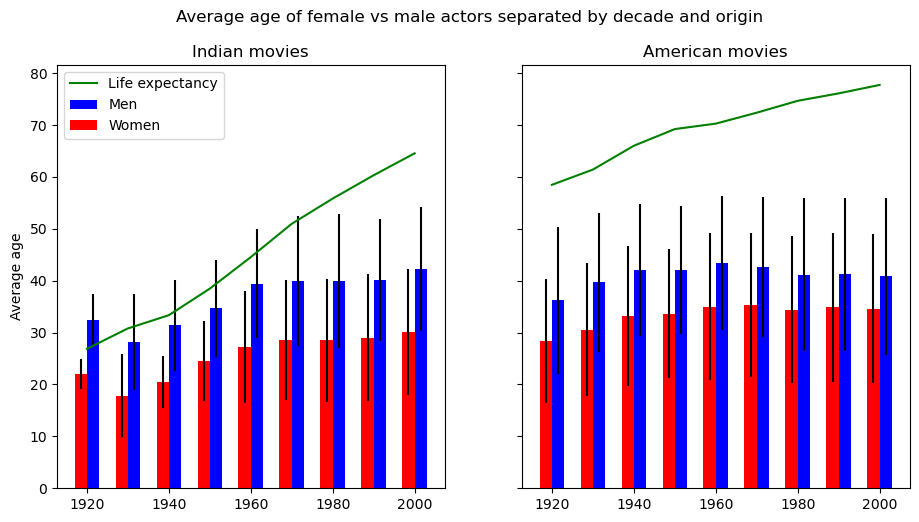

In [108]:
# Compute some stats for the Indian and US movies and plot them by decade for each genre
indian_age = stats_age_decade(indian_charadata)
american_age = stats_age_decade(american_charadata)

# life expectancy for the decades form 1920 to 2000 driven from Statista
life_exp_ind = [26.865, 30.79,33.34, 38.455, 44.52, 50.94, 55.8, 60.295, 64.515] #https://www.statista.com/statistics/1041383/life-expectancy-india-all-time/
life_exp_us = [58.45, 61.385, 65.97, 69.185, 70.235, 72.34, 74.63, 76.06, 77.685] #https://www.statista.com/statistics/1040079/life-expectancy-united-states-all-time/

fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(11, 5.5), sharex = True, sharey = True)
width = 3

ax0.bar(indian_age[0].index + width/2, indian_age[0],width, yerr = indian_age[1],label='Men', color = 'blue')
ax0.bar(indian_age[2].index - width/2, indian_age[2],width, yerr = indian_age[3],  label='Women', color = 'red')
ax0.plot(indian_age[0].index, life_exp_ind, label='Life expectancy', color = 'green')

ax1.bar(american_age[0].index + width/2, american_age[0],width, yerr = american_age[1],label='Men', color = 'blue')
ax1.bar(american_age[2].index - width/2, american_age[2],width, yerr = american_age[3],  label='Women', color = 'red')
ax1.plot(american_age[0].index, life_exp_us, label='Life expectancy', color = 'green')



ax0.set_title('Indian movies')
ax1.set_title('American movies')

ax0.set_ylabel('Average age')

ax0.legend(loc='upper left')

fig.suptitle('Average age of female vs male actors separated by decade and origin')


FIG_NAME = 'age_geograph.svg'

fig.savefig(JPEG_PATH + FIG_NAME, format='svg', dpi=1200)

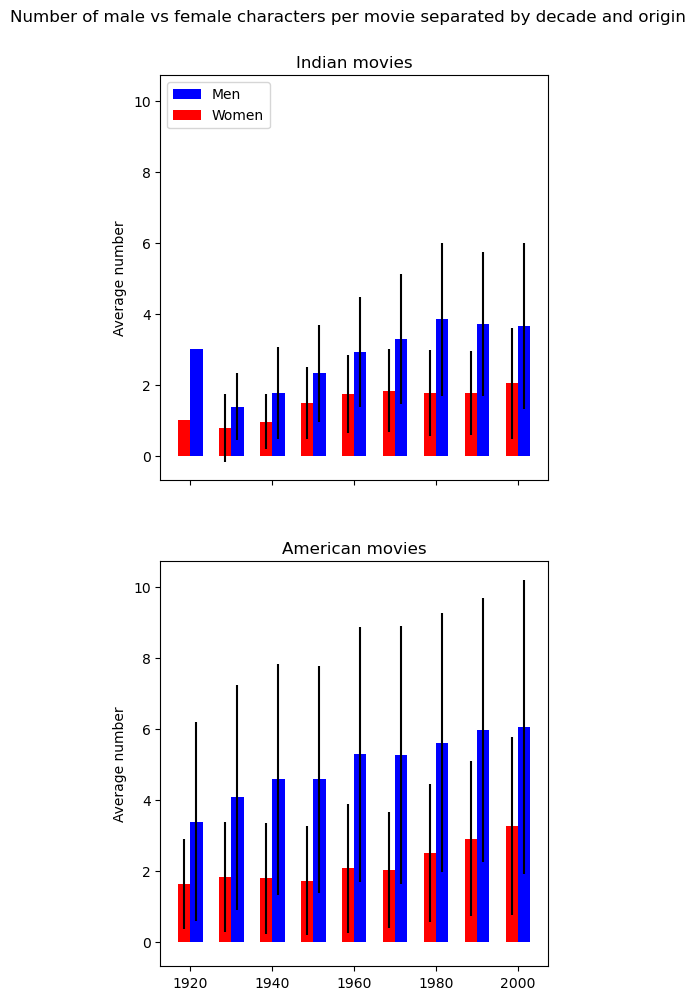

In [109]:
#Plot the average number of men vs women for each India and the US over time

width = 3
india_nb_men = indian_movies.groupby(['decade'])['nb_men']
india_nb_women = indian_movies.groupby(['decade'])['nb_women']
american_nb_men = american_movies.groupby(['decade'])['nb_men']
american_nb_women = american_movies.groupby(['decade'])['nb_women']

fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(5, 11), sharex = True, sharey = True)

ax0.bar(indian_movies['decade'].sort_values().unique() + width/2, india_nb_men.mean(),width, yerr = india_nb_men.std(),label='Men', color = 'blue')
ax0.bar(indian_movies['decade'].sort_values().unique() - width/2, india_nb_women.mean(),width, yerr = india_nb_women.std(),  label='Women', color = 'red')
ax1.bar(american_movies['decade'].sort_values().unique() + width/2, american_nb_men.mean(),width, yerr = american_nb_men.std(),label='Men', color = 'blue')
ax1.bar(american_movies['decade'].sort_values().unique() - width/2, american_nb_women.mean(),width, yerr = american_nb_women.std(),  label='Women', color = 'red')


ax0.set_title('Indian movies')
ax1.set_title('American movies')

ax0.set_ylabel('Average number')
ax1.set_ylabel('Average number')

ax0.legend(loc='upper left')

fig.suptitle('Number of male vs female characters per movie separated by decade and origin')
fig.subplots_adjust(top=0.92)

In [110]:
#Count male and female characters per decade across all movies
gender_count_indian = indian_charadata.groupby('decade').apply(lambda x : pd.Series({'M' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'F' : x[x.actor_gender == 'F'].shape[0]}))
gender_count_indian['proportion_f'] = gender_count_indian.F * 100 / (gender_count_indian.M + gender_count_indian.F)
gender_count_indian.reset_index(inplace = True)
gender_count_indian.sort_values(by = "decade", inplace = True)

gender_count_american = american_charadata.groupby('decade').apply(lambda x : pd.Series({'M' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'F' : x[x.actor_gender == 'F'].shape[0]}))
gender_count_american['proportion_f'] = gender_count_american.F * 100 / (gender_count_american.M + gender_count_american.F)
gender_count_american.reset_index(inplace = True)
gender_count_american.sort_values(by = "decade", inplace = True)

# Create figure with secondary y-axis
fig = make_subplots(rows=1, cols=2, shared_xaxes = True, shared_yaxes = True, specs=[[{"secondary_y": True,}, {"secondary_y": True,}]],subplot_titles = ["Indian movies", "American movies"])

blue, red = px.colors.qualitative.Plotly[0], px.colors.qualitative.Plotly[1]

# Add traces
fig.add_trace(go.Bar(name = 'Count', x = gender_count_indian['decade'], y = gender_count_indian['F'], marker_color = blue),
    secondary_y = False, row = 1, col = 1
)
fig.add_trace(go.Scatter(name = 'Proportion', x=gender_count_indian['decade'], y=gender_count_indian['proportion_f'], line=dict(width=2, color=red), marker=dict(color=red)),
    secondary_y = True, row = 1, col = 1
)
fig.add_trace(go.Bar(name = 'Count of female characters', x = gender_count_american['decade'], y = gender_count_american['F'],showlegend=False, marker_color = blue),
    secondary_y = False, row = 1, col = 2   
)
fig.add_trace(go.Scatter(name = 'Proportion of female characters', x=gender_count_american['decade'], y=gender_count_american['proportion_f'],showlegend=False, line=dict(width=2, color=red), marker=dict(color=red)),
    secondary_y = True, row = 1, col = 2  
)

# Add figure title
fig.update_layout(
    title_text="<b>Count and proportion of female characters per decade",
    legend=dict(
        yanchor="bottom",
        y=0.3,
        xanchor="right",
        x=0.21
    )
)

# Set x-axis title
fig.update_xaxes(title_text="Decade")

# Set y-axes titles
fig.update_yaxes(range = [0,20000], row = 1, secondary_y = False)
fig.update_yaxes(title_text = "Count", secondary_y = False, row = 1, col = 1)
fig.update_yaxes(range = [0,40], row = 1, secondary_y = True)
fig.update_yaxes(title_text = "Proportion of females [%]", secondary_y = True, row = 1, col = 2)


fig.show()


FIG_NAME = 'Count_proportion_geographical.svg'
pio.write_image(fig, file = JPEG_PATH + FIG_NAME, format = "svg")

In [111]:
# select 170 random movies per decade from 60 to process a langage analysis on the plot summaries.
rng = np.random.default_rng(7)

# We do not have sufficent Indian movies to perform the analysis before 1960
decades = np.arange(1960,2001,10)

size = 170

indian_la, indian_la_charadata = langage_analysis(indian_movies, indian_charadata, decades, size)
american_la, american_la_charadata = langage_analysis(american_movies,american_charadata,decades,size)

172
266
426
618
1574
748
905
1593
2651
4190


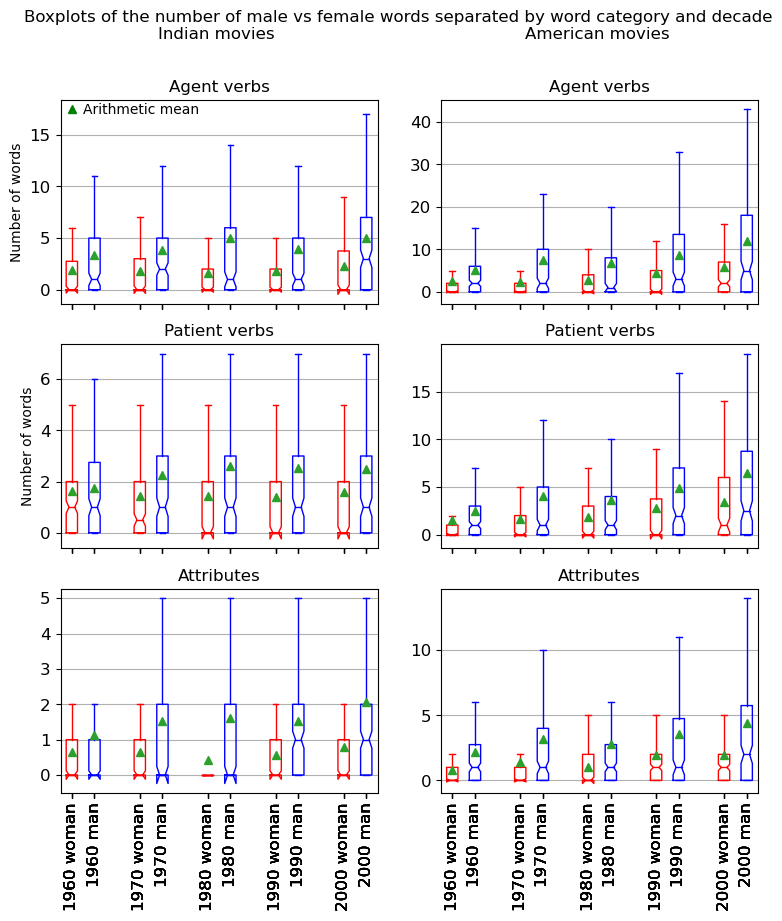

In [112]:
#Plot the average number of men vs women words for each word category separated by decade
fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(9, 9), sharex = True, sharey = False)

decades = np.arange(1960,2001,10)

for i, type in enumerate([indian_la,american_la]):
    grp = type.groupby(['decade'])

    woman_pos = np.arange(1,len(decades)*3, 3)
    man_pos = np.arange(2,len(decades)*3, 3)

    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['agent_woman'],showfliers=False, showmeans = True, ax=axs[0][i],
    positions = woman_pos,color='r', notch =True)
    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['agent_man'],showfliers=False, showmeans = True,ax=axs[0][i],
    positions = man_pos,color='b', notch =True)
    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['patient_woman'],showfliers=False, showmeans = True, ax=axs[1][i],
    positions = woman_pos,color='r', notch =True)
    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['patient_man'],showfliers=False, showmeans = True,ax=axs[1][i],
    positions = man_pos,color='b', notch =True)
    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['attributes_woman'],showfliers=False, showmeans = True, ax=axs[2][i],
    positions = woman_pos,color='r', notch =True)
    grp.boxplot(subplots=False, rot=90, fontsize=12, column = ['attributes_man'],showfliers=False, showmeans = True,ax=axs[2][i],
    positions = man_pos,color='b', notch =True)


#set the x ticks labels to visualize decade and gender and the titles of each subplot
x_labels = []
for i,type in enumerate(["Indian","American"]):

    axs[0][i].set_title(str(type) + ' movies \n\n\nAgent verbs')
    axs[1][i].set_title('Patient verbs')
    axs[2][i].set_title('Attributes')
    axs[i][0].set_ylabel('Number of words')
    x_labels += [""] * (4 * len(decades))
    for i, dec in enumerate(decades):
        x_labels += [str(dec) + " woman"]
    for i, dec in enumerate(decades):
        x_labels += [str(dec) + " man"]
    


axs[2][1].set_xticklabels(x_labels)

#add legend for arithmetic mean
axs[0][0].plot(1,17.5,"g^")
axs[0][0].text(1.5,17,"Arithmetic mean")

for axs_ in axs:
    for ax in axs_:
        ax.grid(axis = 'x')

fig.suptitle('Boxplots of the number of male vs female words separated by word category and decade')

plt.show()

In [113]:
indian_grp = indian_la.groupby(['decade']) 
american_grp = american_la.groupby(['decade']) 


# Initialize figure
fig = make_subplots(rows=1, cols=2, shared_xaxes = True, shared_yaxes = True, subplot_titles = ["Indian movies", "American movies"])

fig.update_xaxes(title_text="Decade", row=1, col=1)
fig.update_xaxes(title_text="Decade", row=1, col=2)

fig.update_yaxes(range=[0,60])

fig.add_trace(
    go.Scatter(name="Agent verbs", x = decades, y = indian_grp.apply(lambda x : (100 * (x['agent_woman']/x['nb_women'])/(x['agent_man']/x['nb_men'] + x['agent_woman']/x['nb_women'])).mean()),
                line=dict(width=2, color='blue'), marker=dict(color='blue')), row = 1, col = 1   
)

fig.add_trace(
    go.Scatter(name="Agent verbs", x = decades, y = american_grp.apply(lambda x : (100 * (x['agent_woman']/x['nb_women'])/(x['agent_man']/x['nb_men'] + x['agent_woman']/x['nb_women'])).mean()),
                showlegend=False, line=dict(width=2, color='blue'), marker=dict(color='blue')), row = 1, col = 2 
)

fig.add_trace(
    go.Scatter(name="Patient verbs", x = decades, y = indian_grp.apply(lambda x : (100 * (x['patient_woman']/x['nb_women'])/(x['patient_man']/x['nb_men'] + x['patient_woman']/x['nb_women'])).mean()),
                line=dict(width=2, color='tomato'), marker=dict(color='tomato')), row = 1, col = 1
)

fig.add_trace(
    go.Scatter(name="Patient verbs", x = decades, y = american_grp.apply(lambda x : (100 * (x['patient_woman']/x['nb_women'])/(x['patient_man']/x['nb_men'] + x['patient_woman']/x['nb_women'])).mean()),
                showlegend=False, line=dict(width=2, color='tomato'), marker=dict(color='tomato')), row = 1, col = 2
)

fig.add_trace(
    go.Scatter(name="Attributes", x = decades, y = indian_grp.apply(lambda x : (100 * (x['attributes_woman']/x['nb_women'])/(x['attributes_man']/x['nb_men'] + x['attributes_woman']/x['nb_women'])).mean()),
                line=dict(width=2, color='green'), marker=dict(color='green')), row = 1, col = 1
)

fig.add_trace(
    go.Scatter(name="Attributes", x = decades, y = american_grp.apply(lambda x : (100 * (x['attributes_woman']/x['nb_women'])/(x['attributes_man']/x['nb_men'] + x['attributes_woman']/x['nb_women'])).mean()),
                showlegend=False, line=dict(width=2, color='green'), marker=dict(color='green')), row = 1, col = 2
)


#Show by default all types of words (agent/patient verbs + attributes)
for i in range(len(fig.data)):
    fig.data[i].visible = True 


# Add dropdown list
fig.update_layout(
    yaxis_title = "Average proportion of words per women[%]",
    xaxis_title = "Decade",
    title_text = "<b>Average percentage of allocation of words to women per movie",

    legend=dict(
        yanchor="bottom",
        y=0.1,
        xanchor="right",
        x=0.8
    )
)

fig.show()

FIG_NAME = 'word_proportion_geograph.html'

pio.write_html(fig, file = HTML_PATH + FIG_NAME, auto_open=False)

### Wordcloud India vs US

In [114]:
#Load the masks 
mask_India = np.array(Image.open("Mask/India.png"))
mask_US = np.array(Image.open("Mask/USA.png"))

#Create output directories
os.makedirs("WordCloud/India_vs_US/India/",exist_ok=True)
os.makedirs("WordCloud/India_vs_US/US/",exist_ok=True)

path_India = "WordCloud/India_vs_US/India/"
path_US = "WordCloud/India_vs_US/US/"


In [115]:
decades = np.arange(1960,2001,10)

wordcloud_decade(indian_la_charadata,decades,path_India,False,mask_India)
wordcloud_era(indian_la_charadata,decades,path_India,False,mask_India)

wordcloud_decade(american_la_charadata,decades,path_US,False,mask_US)
wordcloud_era(american_la_charadata,decades,path_US,False,mask_US)

### Additional dataset: population's reception to women-empowering movies

Metacritic website gathers critiques given by professional movie critics and computes them into a `metascore`. We can use this metascore to assess how movies with important and active main female characters were received by the society at the time the movie aired.

In [116]:
# Get metascore from already parsed metascore website
url = "https://raw.githubusercontent.com/miazhx/metacritic/master/data/metacritic_movies.csv"
metascore = pd.read_csv(url)
metascore.head()

,movie_title,release_date,genre,meta_mixed,meta_negative,meta_positive,metascore,user_mixed,user_negative,user_positive,userscore
0,Anatomy of a Murder,1-Jul-59,"Drama,Mystery,Thriller,Crime",0,0,15,95,0,0,3,tbd
1,Bringing Up Baby,18-Feb-38,"Comedy,Romance,Family",0,1,16,91,1,0,2,tbd
2,After Life,12-May-99,"Drama,Fantasy",0,0,19,91,0,2,1,tbd
3,Gavagai,3-Aug-18,Drama,1,0,6,91,0,1,2,tbd
4,The Hustler,25-Sep-61,"Drama,Sport",1,0,17,90,0,0,3,tbd


In [117]:
metascore.release_date = pd.to_datetime(metascore.release_date.astype(str), errors = 'coerce')
metascore['year'] = pd.DatetimeIndex(metascore['release_date']).year

In [118]:
metascore.year = metascore['year'].apply(lambda x : x - 100 if x > 2013 else x)

In [119]:
# We keep movies for which we have a metascore
metascore.movie_title = metascore.movie_title.str.lower()
moviedata_filtered.movie_name = moviedata_filtered.movie_name.str.lower()

metascore_filtered = metascore[metascore["movie_title"].isin(moviedata_filtered.movie_name)]
print("We have {} movies which have a metascore.".format(len(metascore_filtered)))

We have 4374 movies which have a metascore.


In [120]:
metascore_filtered.head()

,movie_title,release_date,genre,meta_mixed,meta_negative,meta_positive,metascore,user_mixed,user_negative,user_positive,userscore,year
0,anatomy of a murder,2059-07-01,"Drama,Mystery,Thriller,Crime",0,0,15,95,0,0,3,tbd,1959
1,bringing up baby,2038-02-18,"Comedy,Romance,Family",0,1,16,91,1,0,2,tbd,1938
2,after life,1999-05-12,"Drama,Fantasy",0,0,19,91,0,2,1,tbd,1999
4,the hustler,2061-09-25,"Drama,Sport",1,0,17,90,0,0,3,tbd,1961
5,the circus,2029-01-01,"Comedy,Romance",0,0,7,90,0,0,3,tbd,1929


We have a quite high number of movies with a metascore we can proceed to further analysis 

In [121]:
moviedata_score = moviedata_filtered.reset_index().merge(metascore_filtered, suffixes=('', '_2'), how="inner", left_on=["movie_name","release"], right_on=["movie_title","year"]).set_index('wiki_id')#.drop(columns= ["WikiQID"])
len(moviedata_score)

3141

In [122]:
moviedata_score.head(2)

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre,...,genre,meta_mixed,meta_negative,meta_positive,metascore,user_mixed,user_negative,user_positive,userscore,year_2
wiki_id,,,,,,,,,,,,,,,,,,,,,
1952976,dark water,2005,[United States of America],"[Horror, Drama, Thriller]",2000,5,0,0,1,1,...,"Drama,Thriller,Horror",15,5,15,52,23,14,158,8.7,2005
12978934,the deep end of the ocean,1999,[United States of America],"[Family Drama, Drama, Family Film, Film adapta...",1990,9,0,0,0,0,...,Drama,16,5,7,45,3,2,10,6.9,1999


In [123]:
moviedata_filtered[moviedata_filtered.movie_name.isin(moviedata_filtered[moviedata_filtered.duplicated(['movie_name','release'])].movie_name) & moviedata_filtered.release.isin(moviedata_filtered[moviedata_filtered.duplicated(['movie_name','release'])].release)].sort_values('movie_name')

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
12864134,angel,2007,[Puerto Rico],[Drama],2000,7,0,0,0,0
14969658,angel,2007,"[France, Belgium, United Kingdom]","[Drama, Romance Film, Parody, Film adaptation,...",2000,7,1,0,0,1
25080803,bad karma,2002,[United States of America],"[Slasher, Psychological thriller, Thriller, Ho...",2000,2,0,0,1,1
25489035,bad karma,2002,[United Kingdom],"[Short Film, Splatter film]",2000,2,0,0,0,0
3529964,black rain,1989,[United States of America],"[Drama, Action/Adventure, Suspense, Action, Th...",1980,9,0,1,0,1
3608663,black rain,1989,[Japan],"[Drama, War film, Japanese Movies, World cinema]",1980,9,0,0,0,0
21356182,buried alive,2007,[],"[Horror, Supernatural]",2000,7,0,0,1,1
11600310,buried alive,1990,"[United States of America, South Africa]","[Indie, Horror]",1990,0,0,0,1,1
36036213,buried alive,1990,[United States of America],"[Thriller, Horror]",1990,0,0,0,1,1


In [124]:
charadata_score = charadata_filtered.loc[moviedata_score.index.unique()]
movie_score = moviedata_filtered.loc[moviedata_score.index.unique()]

#Create and initialise colums of the dataframe to count agent verbs, patient verbs and attributes for each character and each movie

charadata_score['agent'] = [[]]*len(charadata_score)
charadata_score['patient'] = [[]]*len(charadata_score)
charadata_score['attributes'] = [[]]*len(charadata_score)


movie_score = movie_score.assign(agent_woman = lambda x : 0)
movie_score = movie_score.assign(patient_woman = lambda x : 0)
movie_score = movie_score.assign(attributes_woman = lambda x : 0)
movie_score = movie_score.assign(agent_man = lambda x : 0)
movie_score = movie_score.assign(patient_man = lambda x : 0)
movie_score = movie_score.assign(attributes_man = lambda x : 0)

charadata_score.reset_index(inplace = True)
charadata_score.head()

,wiki_id,release,character_name,actor_gender,actor_name,actor_age,decade,agent,patient,attributes
0,1952976,2005,Mediator,F,Linda Emond,46.0,2000,[],[],[]
1,1952976,2005,Dahlia,F,Jennifer Connelly,34.0,2000,[],[],[]
2,1952976,2005,Mr. Murray,M,John C. Reilly,40.0,2000,[],[],[]
3,1952976,2005,Jeff Platzer,M,Tim Roth,44.0,2000,[],[],[]
4,1952976,2005,Kyle Williams,M,Dougray Scott,39.0,2000,[],[],[]


In [125]:
extract_xml(movie_score,charadata_score)
charadata_score.tail()

,wiki_id,release,character_name,actor_gender,actor_name,actor_age,decade,agent,patient,attributes
39640,277160,1999,Haas,M,Kevin McNally,43.0,1990,[],[],[]
39641,277160,1999,Conrad Greene,M,Maury Chaykin,49.0,1990,[],[],[]
39642,277160,1999,Robert MacDougall,M,Sean Connery,68.0,1990,[],[],[MacDougal]
39643,277160,1999,Virginia Baker,F,Catherine Zeta-Jones,29.0,1990,[investigator],[],[Baker]
39644,277160,1999,Aaron Thibadeaux,M,Ving Rhames,39.0,1990,[],[],[]


In [126]:
movie_score['ratio_agent'] = movie_score.agent_woman / (movie_score.agent_woman + movie_score.agent_man)
movie_score['ratio_patient'] = movie_score.patient_woman / (movie_score.patient_woman + movie_score.patient_man)
movie_score['ratio_attributes'] = movie_score.attributes_woman / (movie_score.attributes_woman + movie_score.attributes_man)
movie_score.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre,agent_woman,patient_woman,attributes_woman,agent_man,patient_man,attributes_man,ratio_agent,ratio_patient,ratio_attributes
wiki_id,,,,,,,,,,,,,,,,,,,
1952976,dark water,2005,[United States of America],"[Horror, Drama, Thriller]",2000,5,0,0,1,1,21,6,4,9,7,2,0.700000,0.461538,0.666667
12978934,the deep end of the ocean,1999,[United States of America],"[Family Drama, Drama, Family Film, Film adapta...",1990,9,0,0,0,0,4,2,3,19,15,7,0.173913,0.117647,0.300000
5425205,eastern promises,2007,"[United States of America, Canada, United King...","[Drama, Mystery, Crime Thriller, Thriller, Cri...",2000,7,0,0,0,0,9,3,4,25,5,4,0.264706,0.375000,0.500000
529276,jaws: the revenge,1987,[United States of America],"[Action/Adventure, Action, Natural horror film...",1980,7,0,1,1,2,10,8,12,20,16,6,0.333333,0.333333,0.666667
226664,about schmidt,2002,[United States of America],"[Drama, Comedy-drama, Indie, Comedy, Black com...",2000,2,0,0,0,0,36,12,6,19,5,5,0.654545,0.705882,0.545455


In [127]:
movie_score = movie_score.reset_index().merge(metascore_filtered, suffixes=('', '_2'), how="inner", left_on=["movie_name","release"], right_on=["movie_title","year"]).set_index('wiki_id')

In [128]:
movie_score.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre,...,genre,meta_mixed,meta_negative,meta_positive,metascore,user_mixed,user_negative,user_positive,userscore,year_2
wiki_id,,,,,,,,,,,,,,,,,,,,,
1952976,dark water,2005,[United States of America],"[Horror, Drama, Thriller]",2000,5,0,0,1,1,...,"Drama,Thriller,Horror",15,5,15,52,23,14,158,8.7,2005
12978934,the deep end of the ocean,1999,[United States of America],"[Family Drama, Drama, Family Film, Film adapta...",1990,9,0,0,0,0,...,Drama,16,5,7,45,3,2,10,6.9,1999
5425205,eastern promises,2007,"[United States of America, Canada, United King...","[Drama, Mystery, Crime Thriller, Thriller, Cri...",2000,7,0,0,0,0,...,"Drama,Mystery,Thriller,Crime",3,0,32,82,26,51,221,7,2007
529276,jaws: the revenge,1987,[United States of America],"[Action/Adventure, Action, Natural horror film...",1980,7,0,1,1,2,...,"Adventure,Thriller,Horror",1,14,0,15,4,28,3,2.1,1987
226664,about schmidt,2002,[United States of America],"[Drama, Comedy-drama, Indie, Comedy, Black com...",2000,2,0,0,0,0,...,"Drama,Comedy",6,0,34,85,19,13,100,7.5,2002


<AxesSubplot:xlabel='ratio_agent', ylabel='metascore'>

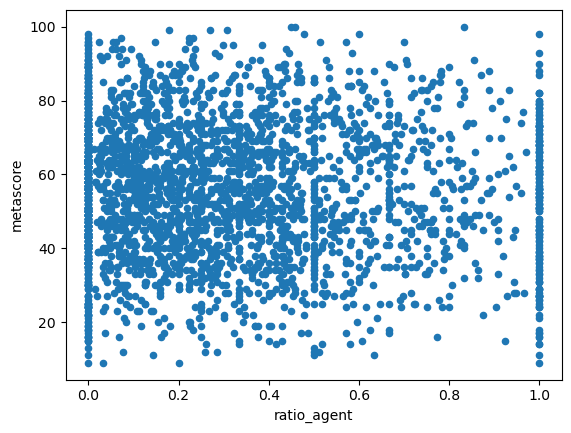

In [129]:
movie_score.plot('ratio_agent','metascore',kind = 'scatter')

<AxesSubplot:xlabel='ratio_patient', ylabel='metascore'>

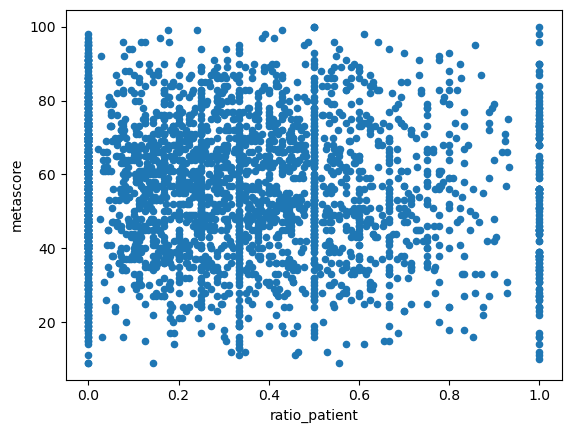

In [130]:
movie_score.plot('ratio_patient','metascore',kind = 'scatter')

<AxesSubplot:xlabel='ratio_attributes', ylabel='metascore'>

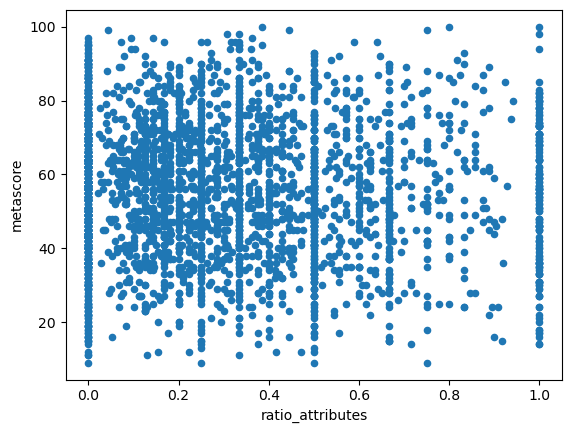

In [131]:
movie_score.plot('ratio_attributes','metascore',kind = 'scatter')

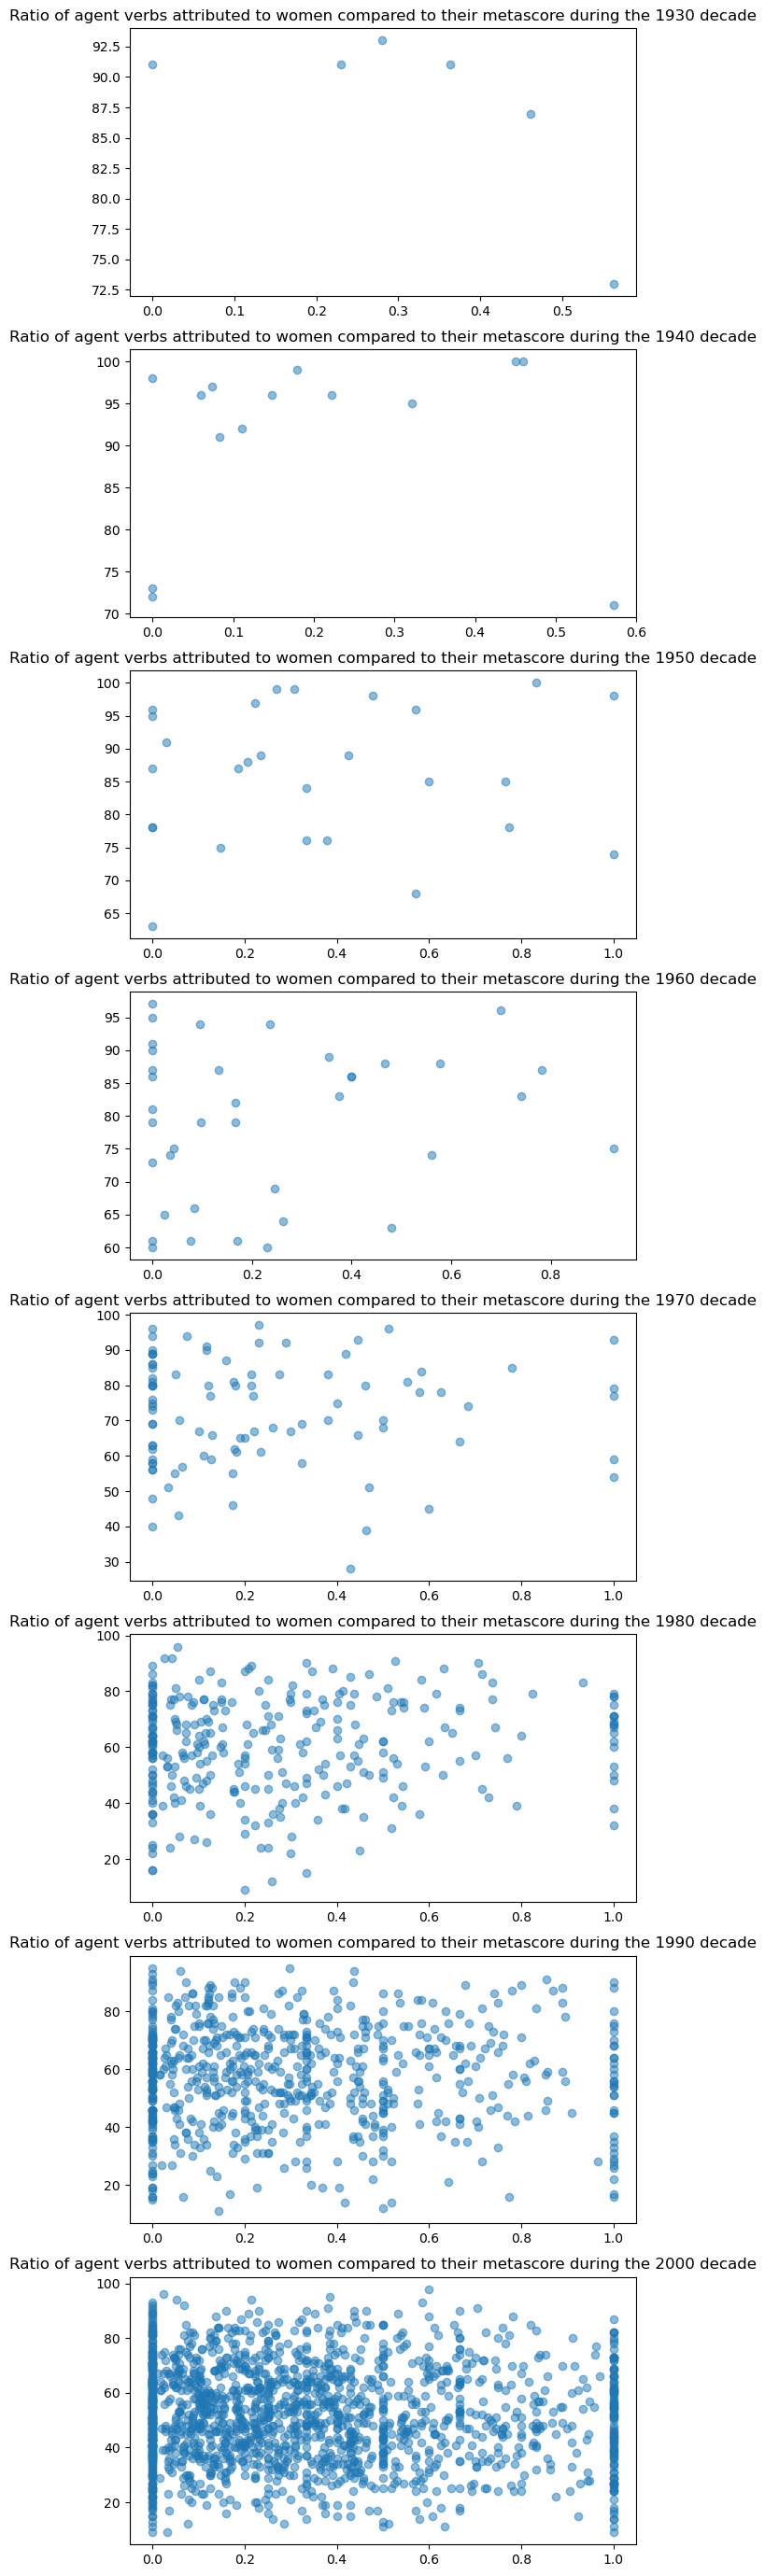

In [132]:
fig,axs=plt.subplots(movie_score['decade'].nunique(),1,figsize=(7, 35))

decades=np.sort(movie_score['decade'].unique())

for i, decade in enumerate(decades) : 
    M = movie_score[movie_score['decade']==decade]
   
    axs[i].scatter(M.ratio_agent, M.metascore, alpha=0.5,label='ratio_agent')
    axs[i].set_title(f"Ratio of agent verbs attributed to women compared to their metascore during the {decade} decade")


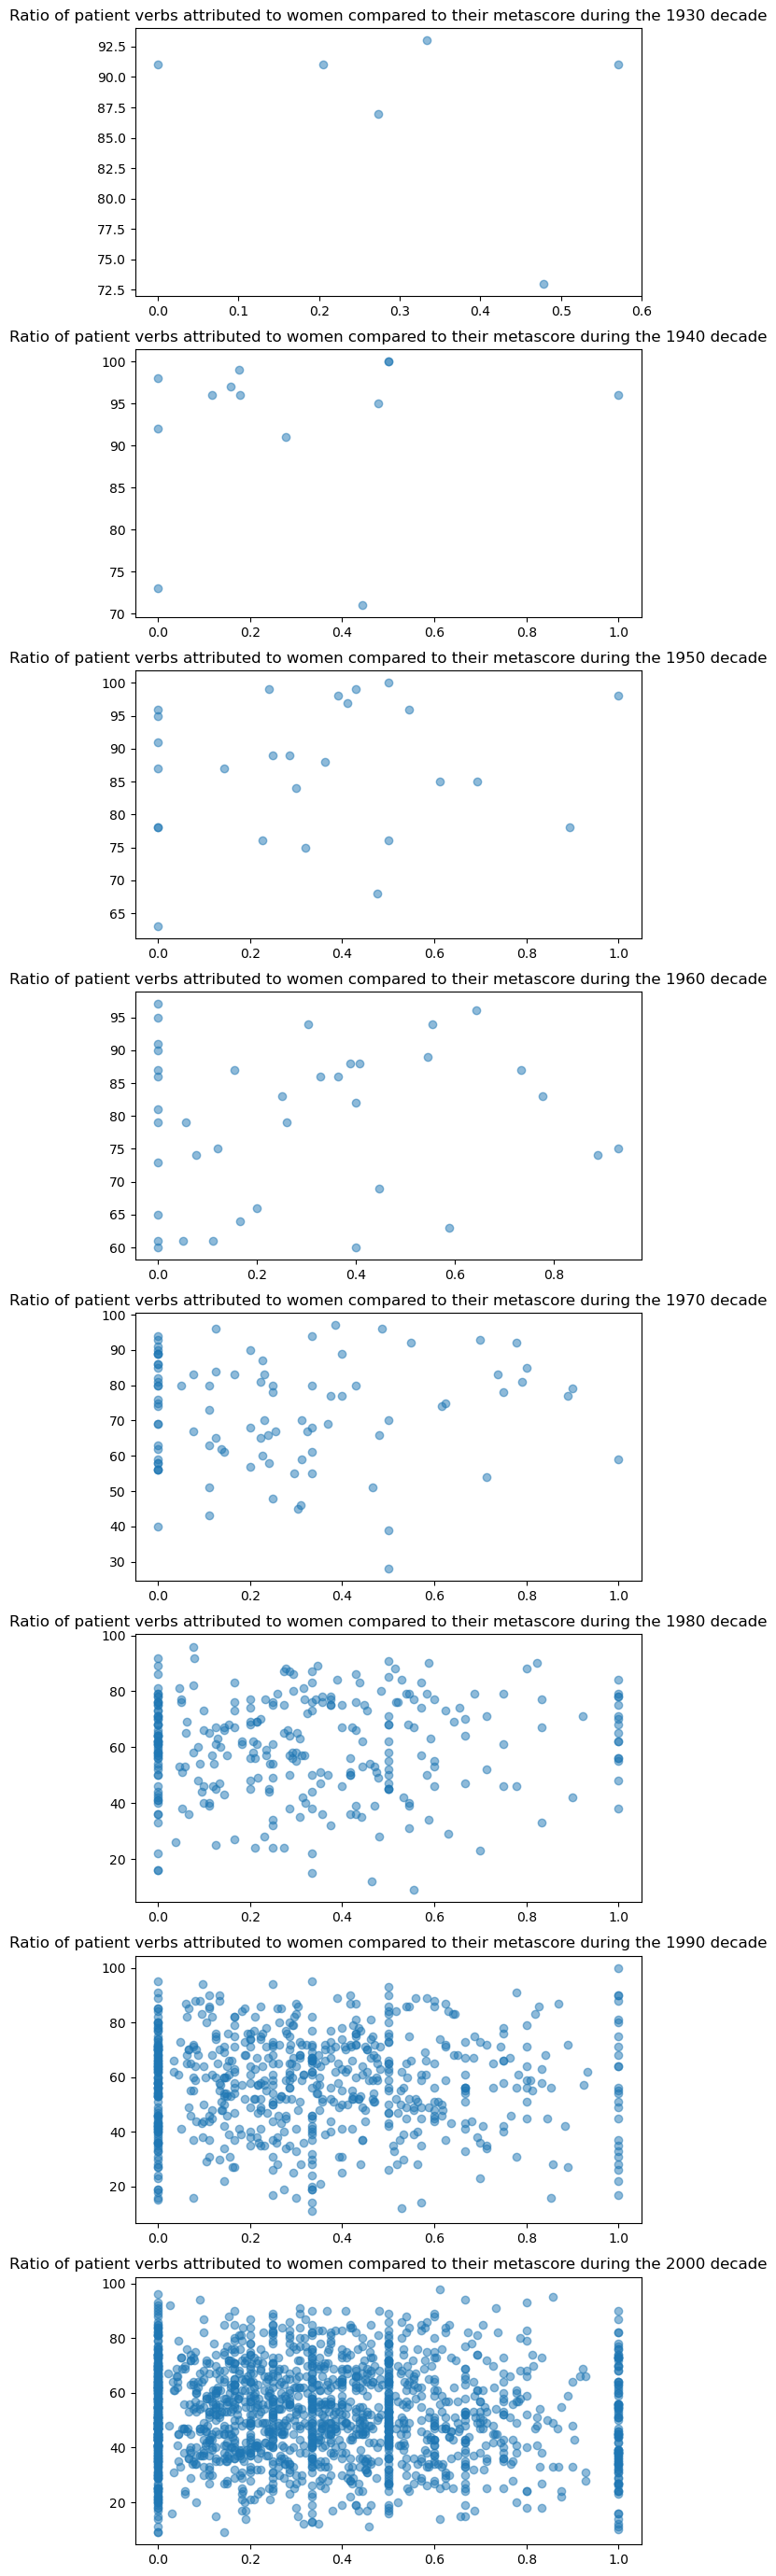

In [133]:
fig,axs=plt.subplots(movie_score['decade'].nunique(),1,figsize=(7, 35))

decades=np.sort(movie_score['decade'].unique())

for i, decade in enumerate(decades) : 
    M = movie_score[movie_score['decade']==decade]
   
    axs[i].scatter(M.ratio_patient, M.metascore, alpha=0.5,label='ratio_patient')
    axs[i].set_title(f"Ratio of patient verbs attributed to women compared to their metascore during the {decade} decade")


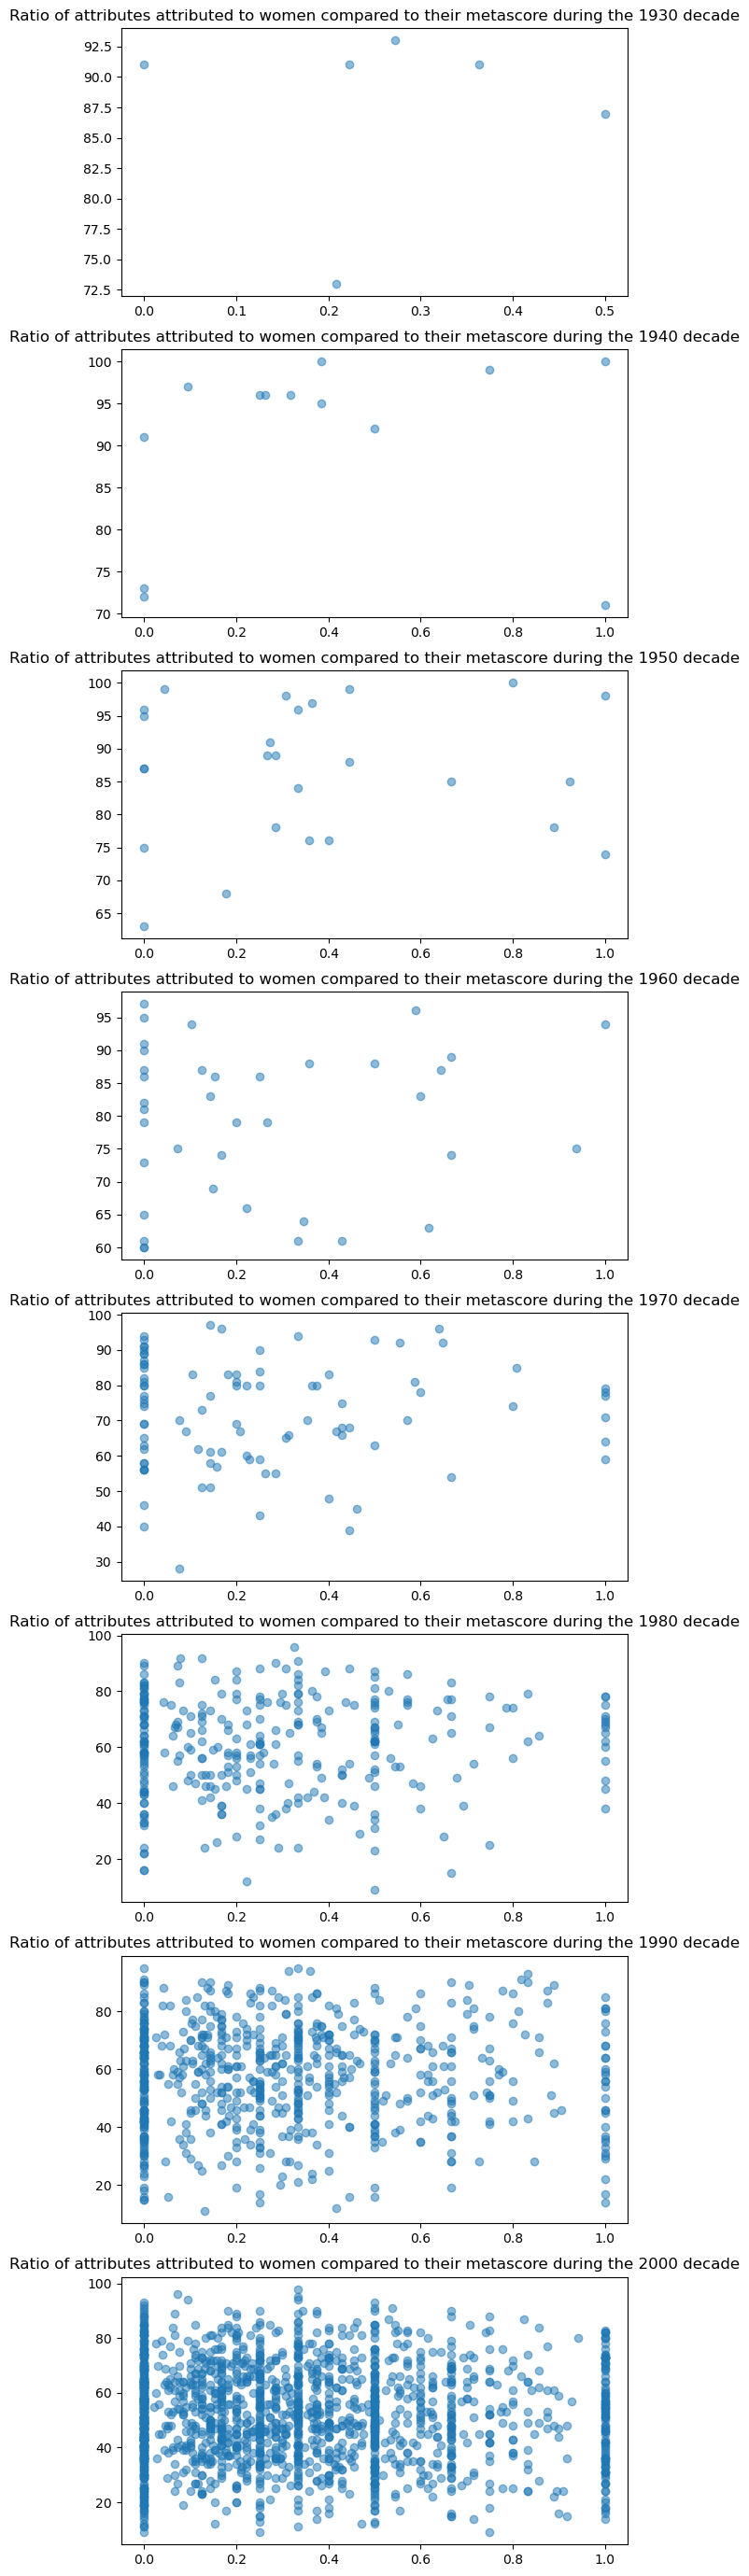

In [134]:
fig,axs=plt.subplots(movie_score['decade'].nunique(),1,figsize=(7, 35))

decades=np.sort(movie_score['decade'].unique())

for i, decade in enumerate(decades) : 
    M = movie_score[movie_score['decade']==decade]
   
    axs[i].scatter(M.ratio_attributes, M.metascore, alpha=0.5,label='ratio_attributes')
    axs[i].set_title(f"Ratio of attributes attributed to women compared to their metascore during the {decade} decade")